## Importing packages & setting up connection

In [1]:
# Import Python packages
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import json
import sys
import cachetools
from datetime import datetime
from datetime import date
import seaborn as sns
import math
from scipy import stats
import statsmodels.api as sm

# Import Snowflake modules
from snowflake.snowpark import Session
import snowflake.snowpark.functions as F
import snowflake.snowpark.types as T
from snowflake.snowpark import Window
from snowflake.snowpark.functions import col, to_date, row_number, desc

# Clustering & Model
from sklearn.cluster import KMeans
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC, SVR
from sklearn. ensemble import RandomForestClassifier, BaggingClassifier, AdaBoostClassifier, ExtraTreesClassifier, RandomForestRegressor, ExtraTreesRegressor, BaggingRegressor, GradientBoostingClassifier, AdaBoostRegressor
from sklearn.neighbors import KNeighborsRegressor
from xgboost import XGBClassifier, XGBRegressor 
from sklearn.model_selection import KFold, cross_val_score, train_test_split

# Scalers
from sklearn.preprocessing import StandardScaler

# Evaluation
from sklearn.metrics import silhouette_score
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.metrics import accuracy_score

# find the best combination of model hyperparameters
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.model_selection import cross_val_score, cross_validate

# Getting Password,Username, Account
import getpass

# ignore warnings
import warnings
warnings.filterwarnings('ignore')

c:\Users\gwyne\.conda\envs\pysnowpark\lib\site-packages\xgboost\compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


In [2]:
# Get account credentials from a json file
with open("account.json") as f:
    data = json.load(f)
    username = data["username"]
    password = data["password"]
    account = data["account"]

# Specify connection parameters
connection_parameters = {
    "account": account,
    "user": username,
    "password": password,
    #"role": "ACCOUNTADMIN",
    #"warehouse": "tasty_ds_wh",
    #"database": "frostbyte_tasty_bytes",
    #"schema": "analytics",
}

# Create Snowpark session
session = Session.builder.configs(connection_parameters).create()

## 1. Loading of Datasets <a id="part1"></a>

In [3]:
# Load the tables as dataframe
order_header_df = session.table("NGEE_ANN_POLYTECHNIC_FROSTBYTE_DATA_SHARE.raw_pos.order_header")
customer_df = session.table("NGEE_ANN_POLYTECHNIC_FROSTBYTE_DATA_SHARE.raw_customer.customer_loyalty")

In [4]:
# Display order_header_df
order_header_df.show()

-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
|"ORDER_ID"  |"TRUCK_ID"  |"LOCATION_ID"  |"CUSTOMER_ID"  |"DISCOUNT_ID"  |"SHIFT_ID"  |"SHIFT_START_TIME"  |"SHIFT_END_TIME"  |"ORDER_CHANNEL"  |"ORDER_TS"           |"SERVED_TS"  |"ORDER_CURRENCY"  |"ORDER_AMOUNT"  |"ORDER_TAX_AMOUNT"  |"ORDER_DISCOUNT_AMOUNT"  |"ORDER_TOTAL"  |
-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
|22477378    |97          |3713.0         |NULL           |NULL           |78881       |16:00:00            |23:00:00          |NULL             |2020-04-

In [5]:
# Display customer_df
customer_df.show()

---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
|"CUSTOMER_ID"  |"FIRST_NAME"  |"LAST_NAME"  |"CITY"     |"COUNTRY"      |"POSTAL_CODE"  |"PREFERRED_LANGUAGE"  |"GENDER"     |"FAVOURITE_BRAND"  |"MARITAL_STATUS"  |"CHILDREN_COUNT"  |"SIGN_UP_DATE"  |"BIRTHDAY_DATE"  |"E_MAIL"                     |"PHONE_NUMBER"  |
---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
|66             |Cannon        |Waters       |Toronto    |Canada         |M4C 3M7        |English               |Male         |NULL               |Married           |4                 |2019-10-08 

In [6]:
# Dropping null values in CUSTOMER_ID
order_header_df = order_header_df.na.drop(subset="CUSTOMER_ID")
order_header_df.show()

-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
|"ORDER_ID"  |"TRUCK_ID"  |"LOCATION_ID"  |"CUSTOMER_ID"  |"DISCOUNT_ID"  |"SHIFT_ID"  |"SHIFT_START_TIME"  |"SHIFT_END_TIME"  |"ORDER_CHANNEL"  |"ORDER_TS"           |"SERVED_TS"  |"ORDER_CURRENCY"  |"ORDER_AMOUNT"  |"ORDER_TAX_AMOUNT"  |"ORDER_DISCOUNT_AMOUNT"  |"ORDER_TOTAL"  |
-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
|22477396    |97          |3713.0         |95165          |NULL           |78881       |16:00:00            |23:00:00          |NULL             |2020-04-

## 2. Dataframe Preparation <a id="part2"></a>

### 2.1 Create dataframe <a id="part2-1"></a>
As mentioned earlier, our group will be focusing on the customers based in the US. Hence, we will need to filter the customer data to US. We are also doing basic data preparation to prepare our datasets so far for subsequent steps. 

In [7]:
# Filtering the customer dataset to only US
us_customer_df = customer_df.filter(F.col("COUNTRY")=="United States")
us_customer_df.show()

-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
|"CUSTOMER_ID"  |"FIRST_NAME"  |"LAST_NAME"  |"CITY"     |"COUNTRY"      |"POSTAL_CODE"  |"PREFERRED_LANGUAGE"  |"GENDER"     |"FAVOURITE_BRAND"  |"MARITAL_STATUS"    |"CHILDREN_COUNT"  |"SIGN_UP_DATE"  |"BIRTHDAY_DATE"  |"E_MAIL"                     |"PHONE_NUMBER"  |
-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
|118            |Donald        |Faulkner     |San Mateo  |United States  |94010          |English               |Male         |NULL               |Single              |0                 |201

In [8]:
# After filtering of customer dataset to only US, we will be filtering and looking at the orders 
# based on these customers only
customer_US = us_customer_df.select(F.col("CUSTOMER_ID"))
order_header_df = order_header_df.join(customer_US, order_header_df.CUSTOMER_ID == customer_US.CUSTOMER_ID, lsuffix = "", rsuffix = "_US")
order_header_df.show()

------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
|"ORDER_ID"  |"TRUCK_ID"  |"LOCATION_ID"  |"CUSTOMER_ID"  |"DISCOUNT_ID"  |"SHIFT_ID"  |"SHIFT_START_TIME"  |"SHIFT_END_TIME"  |"ORDER_CHANNEL"  |"ORDER_TS"           |"SERVED_TS"  |"ORDER_CURRENCY"  |"ORDER_AMOUNT"  |"ORDER_TAX_AMOUNT"  |"ORDER_DISCOUNT_AMOUNT"  |"ORDER_TOTAL"  |"CUSTOMER_ID_US"  |
------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
|451449961   |17          |1789.0         |194230         |NULL           |200540458   |08:00:00 

## 3. Data Exploration <a id="part3"></a>

In [9]:
# Finding current date (last order)
lastest_transaction_de = order_header_df.agg(F.max("ORDER_TS").alias("LAST_ORDER_TS")).collect()[0][0]
lastest_transaction_de

datetime.datetime(2022, 11, 1, 22, 58, 56)

In [10]:
# Finding the last order time stamp for each customer
customer_last_order_de = order_header_df.groupBy("CUSTOMER_ID").agg(F.max("ORDER_TS").alias("LAST_ORDER_TS"))
customer_last_order_de.show()

---------------------------------------
|"CUSTOMER_ID"  |"LAST_ORDER_TS"      |
---------------------------------------
|89063          |2022-09-13 16:27:09  |
|136008         |2022-10-31 16:55:10  |
|118621         |2022-10-25 21:39:53  |
|152251         |2022-10-21 10:28:32  |
|151423         |2022-11-01 11:32:54  |
|104838         |2022-08-06 08:18:18  |
|107986         |2022-10-30 18:30:38  |
|128261         |2022-10-01 20:41:16  |
|150293         |2022-10-04 17:25:53  |
|188668         |2022-10-27 17:02:51  |
---------------------------------------



In [11]:
# Creating a new dataframe and adding column with lastest transaction timestamp as the 
# current date identified previously 

# Inserting new column: current date which the lastest transaction timestamp
customer_recency_de = customer_last_order_de.with_column("CURRENT DATE", F.iff(F.col("LAST_ORDER_TS") == F.col("LAST_ORDER_TS"), lastest_transaction_de, lastest_transaction_de))

# Calculate recency days
customer_recency_de = customer_recency_de.with_column("RECENCY_DAYS", F.datediff('day', customer_recency_de["LAST_ORDER_TS"], customer_recency_de["CURRENT DATE"]))
customer_recency_de.show()

------------------------------------------------------------------------------
|"CUSTOMER_ID"  |"LAST_ORDER_TS"      |"CURRENT DATE"       |"RECENCY_DAYS"  |
------------------------------------------------------------------------------
|166700         |2022-10-29 21:02:53  |2022-11-01 22:58:56  |3               |
|96659          |2022-10-17 20:51:11  |2022-11-01 22:58:56  |15              |
|26806          |2022-10-30 12:50:22  |2022-11-01 22:58:56  |2               |
|189589         |2022-10-31 10:18:00  |2022-11-01 22:58:56  |1               |
|130536         |2022-10-29 13:18:27  |2022-11-01 22:58:56  |3               |
|88139          |2022-10-10 17:19:00  |2022-11-01 22:58:56  |22              |
|27738          |2022-10-30 11:14:50  |2022-11-01 22:58:56  |2               |
|146016         |2022-09-25 09:18:33  |2022-11-01 22:58:56  |37              |
|71452          |2022-10-31 18:46:23  |2022-11-01 22:58:56  |1               |
|56979          |2022-10-20 21:06:43  |2022-11-01 22

In [12]:
customer_by_recency = customer_recency_de.group_by("RECENCY_DAYS").agg(F.count("CUSTOMER_ID").alias("NO_OF_CUST")).to_pandas()
customer_by_recency.head()

,RECENCY_DAYS,NO_OF_CUST
0,1,3120
1,7,2402
2,23,483
3,10,1727
4,14,1012


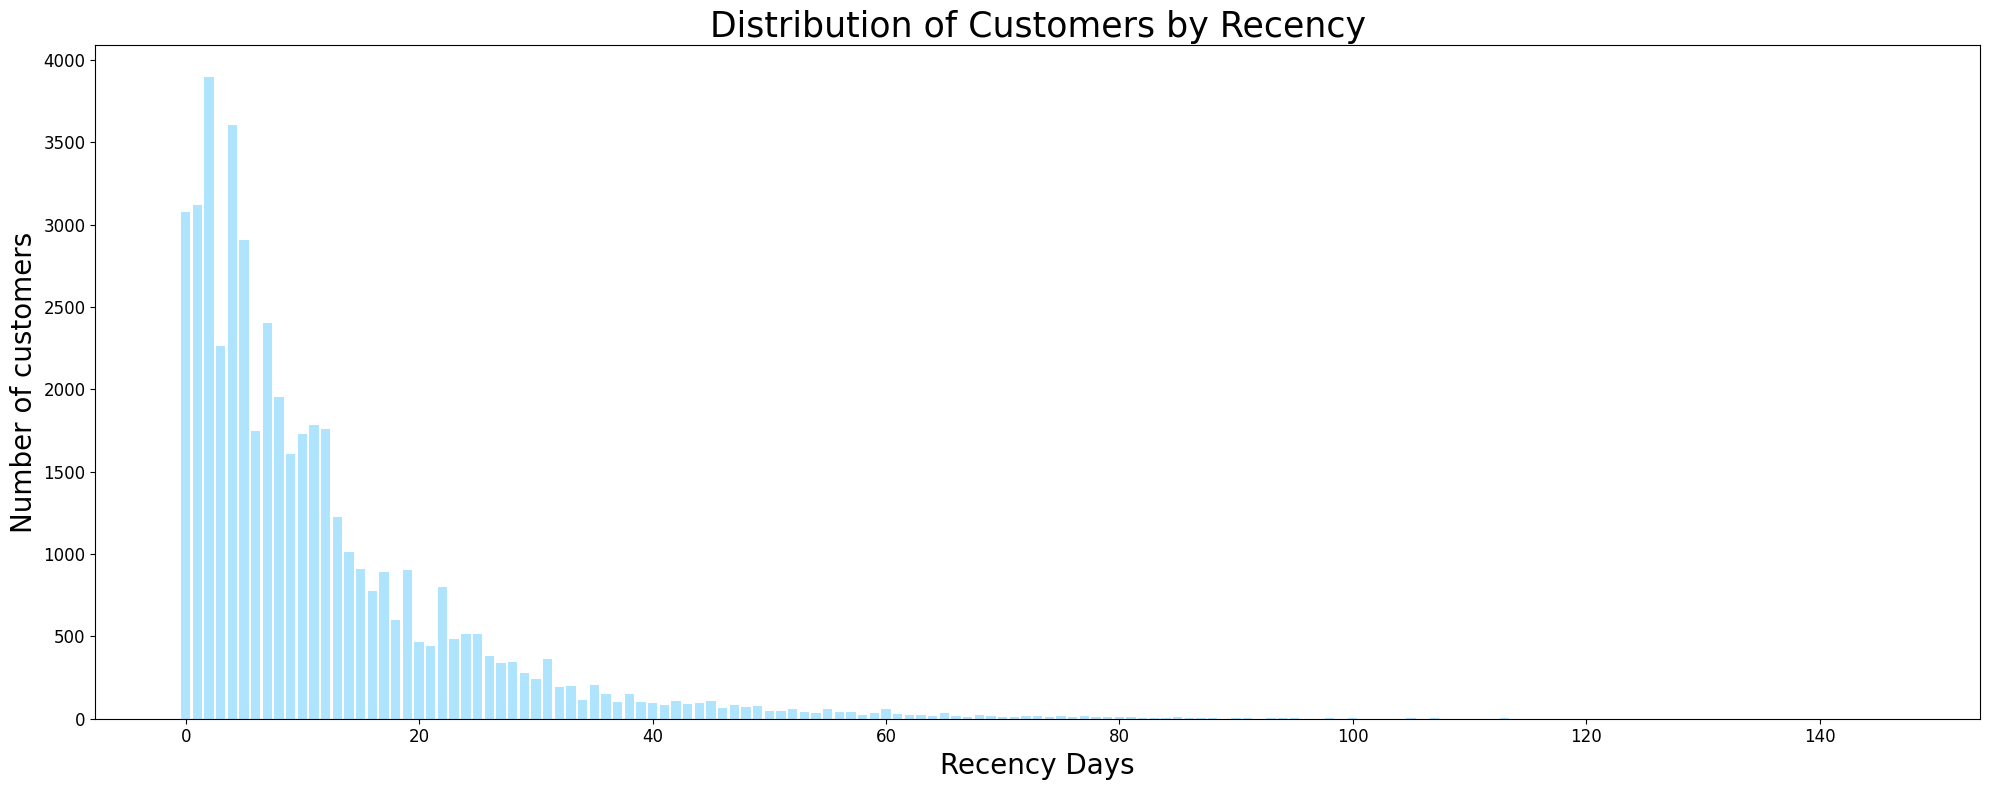

In [13]:
customer_by_recency.sort_values(by='RECENCY_DAYS', ascending=True, inplace=True) # Sort values in ascending order of customer
recency_index = customer_by_recency['RECENCY_DAYS'].tolist()
customer_values = customer_by_recency['NO_OF_CUST'].tolist()

# Create a figure and subplot
fig, V4 = plt.subplots(figsize=(20,8))

# Create a bar chart 
V4.bar(recency_index,customer_values, align = 'center', color='#AFE4FE') # align define the alignment of x-ticks

# Display data labels
#for x,y in zip(recency_index,customer_values):

#    label = x

#    plt.annotate(label, 
#                 (x,y), 
#                 textcoords="offset points", 
#                 xytext=(30,-3), 
#                 fontsize = 10,
#                 ha='center') 

# State title of plot and the axes labels
V4.set_title('Distribution of Customers by Recency', fontsize = 25)
V4.set_ylabel('Number of customers', fontsize = 20)
V4.set_xlabel('Recency Days', fontsize = 20)

# Set font size of ticks on the x-axis and y-axis
V4.tick_params(labelsize = 12, axis ='both')

# Set tight layout for figure
fig.tight_layout()

# Display plot
plt.show()

In [14]:
# Find recency days based on percentage of customer (30%)

# Sort the DataFrame by RECENCY_DAYS in ascending order
customer_by_recency = customer_by_recency.sort_values('RECENCY_DAYS')

# Calculate the cumulative sum of customer counts
customer_by_recency['CUMULATIVE_COUNT'] = customer_by_recency['NO_OF_CUST'].cumsum()

# Find the RECENCY_DAYS where 80% of the customers are at
target_percentage = 0.7
target_recency_days = None

for index, row in customer_by_recency.iterrows():
    if row['CUMULATIVE_COUNT'] >= target_percentage * customer_by_recency['NO_OF_CUST'].sum():
        target_recency_days = row['RECENCY_DAYS']
        break

# Print the result
print("RECENCY_DAYS where 70% of the customers are at:", target_recency_days)

RECENCY_DAYS where 70% of the customers are at: 13


In [15]:
# Sum of customers where RECENCY_DAYS is below or equal to 13
sum_below_13 = customer_by_recency[customer_by_recency['RECENCY_DAYS'] <= 13]['NO_OF_CUST'].sum()

# Sum of customers where RECENCY_DAYS is more than 13
sum_above_13 = customer_by_recency[customer_by_recency['RECENCY_DAYS'] > 13]['NO_OF_CUST'].sum()

# Print the results
print("Sum of customers where RECENCY_DAYS is below or equal to 13:", sum_below_13)
print("Sum of customers where RECENCY_DAYS is more than 13:", sum_above_13)

Sum of customers where RECENCY_DAYS is below or equal to 13: 33053
Sum of customers where RECENCY_DAYS is more than 13: 13247


In food service industry, customer churn rates can range from 20% to 30% annually. For 70% of the customers, their recency days are at 13. Therefore, we round the recenecy days up to 14 days, which is 2 weeks to be considered churned.

For this model, we would be predicting the days to next purchase for each customer. After predicting the days to next purchase, if it is more than 14 days, the customer is considered churned, else not churned.

## 4. Data Preparation <a id="part4"></a>

In [16]:
# Getting last order date
lastest_transaction = order_header_df.agg(F.max("ORDER_TS").alias("LAST_ORDER_TS")).collect()[0][0]
order_header_df = order_header_df.withColumn("LAST_DATE", F.iff(F.col("CUSTOMER_ID") == F.col("CUSTOMER_ID"), lastest_transaction, lastest_transaction))

In [17]:
# Create training dataframee (2019-01-01 to 2022-10-18)
order_14days = order_header_df.filter(F.datediff("day", F.col("ORDER_TS"), F.col("LAST_DATE")) >= 14)

# Ensure timeframe is correct
order_14days.agg(F.min('ORDER_TS')).show()
order_14days.agg(F.max('ORDER_TS')).show()

-----------------------
|"MIN(ORDER_TS)"      |
-----------------------
|2019-01-01 17:19:08  |
-----------------------

-----------------------
|"MAX(ORDER_TS)"      |
-----------------------
|2022-10-18 22:56:45  |
-----------------------



In [18]:
# Display order_14days
order_14days.show()

----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
|"ORDER_ID"  |"TRUCK_ID"  |"LOCATION_ID"  |"CUSTOMER_ID"  |"DISCOUNT_ID"  |"SHIFT_ID"  |"SHIFT_START_TIME"  |"SHIFT_END_TIME"  |"ORDER_CHANNEL"  |"ORDER_TS"           |"SERVED_TS"  |"ORDER_CURRENCY"  |"ORDER_AMOUNT"  |"ORDER_TAX_AMOUNT"  |"ORDER_DISCOUNT_AMOUNT"  |"ORDER_TOTAL"  |"CUSTOMER_ID_US"  |"LAST_DATE"          |
----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
|451449961   |17          |1789

### 4.1 Getting first dataframe <a id="part4.1"></a>

In [19]:
# Get data till 2 weeks before last transaction date provided (first dataframe)
order_df1 = order_14days.filter(F.datediff("day", F.col("ORDER_TS"), F.col("LAST_DATE")) >= 28)
order_df1.show()

----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
|"ORDER_ID"  |"TRUCK_ID"  |"LOCATION_ID"  |"CUSTOMER_ID"  |"DISCOUNT_ID"  |"SHIFT_ID"  |"SHIFT_START_TIME"  |"SHIFT_END_TIME"  |"ORDER_CHANNEL"  |"ORDER_TS"           |"SERVED_TS"  |"ORDER_CURRENCY"  |"ORDER_AMOUNT"  |"ORDER_TAX_AMOUNT"  |"ORDER_DISCOUNT_AMOUNT"  |"ORDER_TOTAL"  |"CUSTOMER_ID_US"  |"LAST_DATE"          |
----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
|451449961   |17          |1789

In [20]:
# Ensure timeframe is correct
order_df1.agg(F.min('ORDER_TS')).show()
order_df1.agg(F.max('ORDER_TS')).show()

-----------------------
|"MIN(ORDER_TS)"      |
-----------------------
|2019-01-01 17:19:08  |
-----------------------

-----------------------
|"MAX(ORDER_TS)"      |
-----------------------
|2022-10-04 22:58:32  |
-----------------------



In [21]:
# Getting the latest purchase date for each customer in df1
customer_last_order_timestamp_df1 = order_df1.groupBy("CUSTOMER_ID").agg(F.max("ORDER_TS").alias("LAST_ORDER_TS"))
customer_last_order_timestamp_df1.show()

---------------------------------------
|"CUSTOMER_ID"  |"LAST_ORDER_TS"      |
---------------------------------------
|63821          |2022-09-23 13:43:38  |
|106975         |2022-09-29 09:47:31  |
|55439          |2022-10-01 17:59:23  |
|199926         |2022-10-04 12:53:44  |
|49601          |2022-10-04 12:06:01  |
|31719          |2022-09-23 21:05:38  |
|136051         |2022-10-02 17:45:01  |
|110317         |2022-09-23 21:11:24  |
|164813         |2022-09-18 19:52:33  |
|36241          |2022-09-27 12:51:50  |
---------------------------------------



In [22]:
# Getting last order date
lastest_transaction_df1 = order_df1.agg(F.max("ORDER_TS").alias("LAST_ORDER_TS")).collect()[0][0]
customer_last_order_timestamp_df1 = customer_last_order_timestamp_df1.withColumn("LAST_TRANS", F.iff(F.col("CUSTOMER_ID") == F.col("CUSTOMER_ID"), lastest_transaction_df1, lastest_transaction_df1))
customer_last_order_timestamp_df1.show()

-------------------------------------------------------------
|"CUSTOMER_ID"  |"LAST_ORDER_TS"      |"LAST_TRANS"         |
-------------------------------------------------------------
|172289         |2022-09-11 16:30:55  |2022-10-04 22:58:32  |
|78907          |2022-09-29 17:16:33  |2022-10-04 22:58:32  |
|160383         |2022-10-01 19:22:35  |2022-10-04 22:58:32  |
|103028         |2022-10-03 08:58:34  |2022-10-04 22:58:32  |
|103838         |2022-09-30 13:43:00  |2022-10-04 22:58:32  |
|61295          |2022-09-12 16:39:09  |2022-10-04 22:58:32  |
|150780         |2022-09-28 10:19:11  |2022-10-04 22:58:32  |
|117288         |2022-09-29 19:49:12  |2022-10-04 22:58:32  |
|65147          |2022-09-24 19:57:45  |2022-10-04 22:58:32  |
|145186         |2022-09-07 17:25:12  |2022-10-04 22:58:32  |
-------------------------------------------------------------



In [23]:
# Getting the date diff from customer last order to the date 2 weeks before the latest provided transaction date in df1
customer_last_order_timestamp_df1 = customer_last_order_timestamp_df1.withColumn("days_df1", F.datediff("day", customer_last_order_timestamp_df1["LAST_ORDER_TS"], customer_last_order_timestamp_df1["LAST_TRANS"]))
customer_last_order_timestamp_df1.show()

--------------------------------------------------------------------------
|"CUSTOMER_ID"  |"LAST_ORDER_TS"      |"LAST_TRANS"         |"DAYS_DF1"  |
--------------------------------------------------------------------------
|191713         |2022-09-24 17:06:56  |2022-10-04 22:58:32  |10          |
|36540          |2022-09-24 18:55:31  |2022-10-04 22:58:32  |10          |
|152297         |2022-09-24 20:01:41  |2022-10-04 22:58:32  |10          |
|80351          |2022-08-28 16:01:37  |2022-10-04 22:58:32  |37          |
|126015         |2022-09-24 09:44:26  |2022-10-04 22:58:32  |10          |
|88089          |2022-10-01 20:35:32  |2022-10-04 22:58:32  |3           |
|34683          |2022-08-27 14:06:27  |2022-10-04 22:58:32  |38          |
|106184         |2022-09-24 14:26:55  |2022-10-04 22:58:32  |10          |
|70563          |2022-09-24 17:42:22  |2022-10-04 22:58:32  |10          |
|75345          |2022-08-24 13:44:21  |2022-10-04 22:58:32  |41          |
-------------------------

### 4.1.1 Calculating the days between the last 3 transactions <a id="part4.1.1"></a>

In [24]:
# create a dataframe with customer id and order datetime
cust_order_dates = order_df1.sort("CUSTOMER_ID")
cust_order_dates = cust_order_dates.select("CUSTOMER_ID", "ORDER_TS")
cust_order_dates.show()

---------------------------------------
|"CUSTOMER_ID"  |"ORDER_TS"           |
---------------------------------------
|22             |2022-07-02 20:00:39  |
|22             |2022-06-11 20:14:09  |
|22             |2022-05-15 13:21:44  |
|22             |2022-09-14 11:40:41  |
|22             |2022-08-24 18:22:41  |
|22             |2022-08-02 19:21:20  |
|22             |2020-08-20 19:20:25  |
|22             |2019-11-20 17:29:15  |
|22             |2022-09-29 20:37:56  |
|22             |2022-09-07 21:16:19  |
---------------------------------------



In [25]:
# extract the date from the datetime
cust_order_dates = cust_order_dates.withColumn('ORDER_DATE', to_date(col('ORDER_TS')))
cust_order_dates = cust_order_dates.drop("ORDER_TS")
cust_order_dates.show()

--------------------------------
|"CUSTOMER_ID"  |"ORDER_DATE"  |
--------------------------------
|22             |2019-05-31    |
|22             |2019-05-15    |
|22             |2021-01-19    |
|22             |2020-03-16    |
|22             |2020-08-20    |
|22             |2021-02-27    |
|22             |2020-07-25    |
|22             |2020-07-29    |
|22             |2020-10-18    |
|22             |2019-11-20    |
--------------------------------



In [26]:
# drop duplicate rows --> some customers may make multiple transactions in a day
cust_order_dates = cust_order_dates.dropDuplicates()
cust_order_dates.show()

--------------------------------
|"CUSTOMER_ID"  |"ORDER_DATE"  |
--------------------------------
|157667         |2022-01-03    |
|157670         |2021-03-02    |
|157691         |2021-05-07    |
|157669         |2021-03-03    |
|157691         |2021-04-03    |
|157675         |2020-05-03    |
|157675         |2020-04-08    |
|157686         |2022-08-01    |
|157691         |2021-11-24    |
|157688         |2021-02-27    |
--------------------------------



In [27]:
# sort the order date by chronological order and by customer id
cust_order_dates = cust_order_dates.sort(["CUSTOMER_ID", col("ORDER_DATE").desc()])
cust_order_dates.show()

--------------------------------
|"CUSTOMER_ID"  |"ORDER_DATE"  |
--------------------------------
|22             |2022-09-29    |
|22             |2022-09-14    |
|22             |2022-09-07    |
|22             |2022-08-24    |
|22             |2022-08-02    |
|22             |2022-07-02    |
|22             |2022-06-11    |
|22             |2022-05-15    |
|22             |2022-03-28    |
|22             |2022-03-16    |
--------------------------------



In [28]:
# find out which customers have less than 3 transactions made on different days
cust_order_dates.groupBy("CUSTOMER_ID").count().filter(col("COUNT") < 3).show()

---------------------------
|"CUSTOMER_ID"  |"COUNT"  |
---------------------------
|               |         |
---------------------------



In [29]:
# since no customers have less than 3 transactions made on different days, get the dates of the last 3 transactions of each customer

# partition the data by customer id and order it by descending order of the date 
partition = Window.partitionBy("CUSTOMER_ID").orderBy(col("ORDER_DATE").desc)

# using lag, get the previous 2 dates and place it into a new column 
cust_order_dates = cust_order_dates.withColumn("ORDER_DATE_2", F.lag(col("ORDER_DATE"), 1).over(Window.partitionBy("CUSTOMER_ID").orderBy(desc("ORDER_DATE"))))
cust_order_dates = cust_order_dates.withColumn("ORDER_DATE_3", F.lag(col("ORDER_DATE"), 2).over(Window.partitionBy("CUSTOMER_ID").orderBy(desc("ORDER_DATE"))))

cust_order_dates.show()

------------------------------------------------------------------
|"CUSTOMER_ID"  |"ORDER_DATE"  |"ORDER_DATE_2"  |"ORDER_DATE_3"  |
------------------------------------------------------------------
|22             |2022-09-29    |NULL            |NULL            |
|22             |2022-09-14    |2022-09-29      |NULL            |
|22             |2022-09-07    |2022-09-14      |2022-09-29      |
|22             |2022-08-24    |2022-09-07      |2022-09-14      |
|22             |2022-08-02    |2022-08-24      |2022-09-07      |
|22             |2022-07-02    |2022-08-02      |2022-08-24      |
|22             |2022-06-11    |2022-07-02      |2022-08-02      |
|22             |2022-05-15    |2022-06-11      |2022-07-02      |
|22             |2022-03-28    |2022-05-15      |2022-06-11      |
|22             |2022-03-16    |2022-03-28      |2022-05-15      |
------------------------------------------------------------------



In [30]:
# drop rows with null
cust_order_dates = cust_order_dates.dropna()
cust_order_dates.show()

------------------------------------------------------------------
|"CUSTOMER_ID"  |"ORDER_DATE"  |"ORDER_DATE_2"  |"ORDER_DATE_3"  |
------------------------------------------------------------------
|156208         |2022-06-20    |2022-07-17      |2022-08-01      |
|156208         |2022-06-11    |2022-06-20      |2022-07-17      |
|156208         |2022-05-26    |2022-06-11      |2022-06-20      |
|156208         |2022-05-24    |2022-05-26      |2022-06-11      |
|156208         |2022-05-09    |2022-05-24      |2022-05-26      |
|156208         |2022-05-02    |2022-05-09      |2022-05-24      |
|156208         |2022-04-05    |2022-05-02      |2022-05-09      |
|156208         |2022-03-11    |2022-04-05      |2022-05-02      |
|156208         |2022-03-05    |2022-03-11      |2022-04-05      |
|156208         |2022-02-27    |2022-03-05      |2022-03-11      |
------------------------------------------------------------------



In [31]:
# choose only the top row for each customer id and put it into a new dataframe
windowSpec = Window.partitionBy("CUSTOMER_ID").orderBy(desc("ORDER_DATE"))

past3_trans = cust_order_dates.withColumn("row_number", row_number().over(windowSpec)).filter(col("row_number") == 1).drop("row_number")

past3_trans.show()

------------------------------------------------------------------
|"CUSTOMER_ID"  |"ORDER_DATE"  |"ORDER_DATE_2"  |"ORDER_DATE_3"  |
------------------------------------------------------------------
|130843         |2022-09-20    |2022-09-28      |2022-09-30      |
|190643         |2022-08-14    |2022-10-01      |2022-10-02      |
|104716         |2022-07-20    |2022-07-21      |2022-08-17      |
|117803         |2022-08-20    |2022-08-22      |2022-09-07      |
|117660         |2022-09-20    |2022-09-24      |2022-09-28      |
|144452         |2022-08-21    |2022-09-10      |2022-09-29      |
|172725         |2022-08-31    |2022-09-04      |2022-09-25      |
|39484          |2022-09-16    |2022-09-30      |2022-10-04      |
|172902         |2022-08-07    |2022-08-25      |2022-10-01      |
|192754         |2022-07-05    |2022-08-08      |2022-09-05      |
------------------------------------------------------------------



In [32]:
# calculate the date difference between each order date
past3_trans = past3_trans.withColumn("TRANS_DATEDIFF1", F.datediff("day", past3_trans["ORDER_DATE"], past3_trans["ORDER_DATE_2"]))
past3_trans = past3_trans.withColumn("TRANS_DATEDIFF2", F.datediff("day", past3_trans["ORDER_DATE_2"], past3_trans["ORDER_DATE_3"]))

past3_trans.show()

----------------------------------------------------------------------------------------------------------
|"CUSTOMER_ID"  |"ORDER_DATE"  |"ORDER_DATE_2"  |"ORDER_DATE_3"  |"TRANS_DATEDIFF1"  |"TRANS_DATEDIFF2"  |
----------------------------------------------------------------------------------------------------------
|156801         |2022-08-30    |2022-09-02      |2022-09-15      |3                  |13                 |
|167625         |2022-09-02    |2022-09-12      |2022-09-20      |10                 |8                  |
|76224          |2022-08-29    |2022-09-12      |2022-09-28      |14                 |16                 |
|137761         |2022-07-28    |2022-08-01      |2022-08-11      |4                  |10                 |
|67164          |2022-09-03    |2022-09-08      |2022-09-27      |5                  |19                 |
|54061          |2022-08-20    |2022-09-03      |2022-09-27      |14                 |24                 |
|148706         |2022-08-26    |2022-

In [33]:
# merge the dataframe with the past 3 transactions with the first dataframe

past3_trans = past3_trans.select("CUSTOMER_ID", "TRANS_DATEDIFF1", "TRANS_DATEDIFF2")

customer_last_order_timestamp_df1 = customer_last_order_timestamp_df1.join(past3_trans, 
                                customer_last_order_timestamp_df1.CUSTOMER_ID==past3_trans.CUSTOMER_ID, lsuffix="", rsuffix="_PAST3_TRANS")

customer_last_order_timestamp_df1 = customer_last_order_timestamp_df1.drop("CUSTOMER_ID_PAST3_TRANS")

customer_last_order_timestamp_df1.show()

------------------------------------------------------------------------------------------------------------------
|"CUSTOMER_ID"  |"LAST_ORDER_TS"      |"LAST_TRANS"         |"DAYS_DF1"  |"TRANS_DATEDIFF1"  |"TRANS_DATEDIFF2"  |
------------------------------------------------------------------------------------------------------------------
|135374         |2022-08-25 08:03:01  |2022-10-04 22:58:32  |40          |5                  |26                 |
|135377         |2022-10-01 09:48:00  |2022-10-04 22:58:32  |3           |4                  |14                 |
|135378         |2022-09-27 19:24:37  |2022-10-04 22:58:32  |7           |2                  |2                  |
|135380         |2022-09-26 19:40:28  |2022-10-04 22:58:32  |8           |6                  |3                  |
|135381         |2022-09-27 20:34:51  |2022-10-04 22:58:32  |7           |6                  |42                 |
|135384         |2022-09-29 15:19:47  |2022-10-04 22:58:32  |5           |12    

#### 4.1.2 Calculation of Average Days between Purchases <a id="part4.1.2"></a>

In [34]:
# Finding the average days between purchase for each customer
customer_order_times = order_df1.sort(col("CUSTOMER_ID"), col("ORDER_TS"))
customer_order_times = customer_order_times.withColumn("prev_order_date", F.lag(col("ORDER_TS"), 1).over(Window.partitionBy("CUSTOMER_ID").orderBy("ORDER_TS"))).withColumn("days_between", F.datediff('day', col("prev_order_date"), col("ORDER_TS")))
customer_average_days = customer_order_times.groupBy("CUSTOMER_ID").avg("days_between")
customer_average_days = customer_average_days.sort(col('CUSTOMER_ID'))
customer_average_days.show()

---------------------------------------
|"CUSTOMER_ID"  |"AVG(DAYS_BETWEEN)"  |
---------------------------------------
|22             |32.447368            |
|42             |34.555556            |
|59             |34.194444            |
|65             |29.536585            |
|106            |24.622222            |
|118            |29.540541            |
|166            |19.214286            |
|176            |28.718750            |
|189            |27.777778            |
|204            |30.187500            |
---------------------------------------



In [35]:
# Adding the average days between purchase into customer_last_order_timestamp_df1
customer_last_order_timestamp_df1 = customer_average_days.join(customer_last_order_timestamp_df1, 
                                customer_last_order_timestamp_df1.CUSTOMER_ID==customer_average_days.CUSTOMER_ID, lsuffix="", rsuffix="_AVG_DAYS_WITHOUT_PURCHASE")
customer_last_order_timestamp_df1.show()

----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
|"CUSTOMER_ID"  |"AVG(DAYS_BETWEEN)"  |"CUSTOMER_ID_AVG_DAYS_WITHOUT_PURCHASE"  |"LAST_ORDER_TS"      |"LAST_TRANS"         |"DAYS_DF1"  |"TRANS_DATEDIFF1"  |"TRANS_DATEDIFF2"  |
----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
|122890         |17.847458            |122890                                   |2022-09-29 11:33:42  |2022-10-04 22:58:32  |5           |33                 |11                 |
|123251         |22.625000            |123251                                   |2022-10-01 21:51:25  |2022-10-04 22:58:32  |3           |11                 |4                  |
|198834         |18.034483            |198834                                   |2022-09-30 21:49:14  |20

### 4.1.3 Calculation the Minimum Number of Days without Customer Purchase <a id="part4.1.3"></a>

In [36]:
# Finding the minimum days without purchase for each customer
customer_min_days = customer_order_times.groupBy("CUSTOMER_ID").min("days_between")
customer_min_days = customer_min_days.sort(col('CUSTOMER_ID'))
customer_min_days.show()

---------------------------------------
|"CUSTOMER_ID"  |"MIN(DAYS_BETWEEN)"  |
---------------------------------------
|22             |1                    |
|42             |1                    |
|59             |1                    |
|65             |2                    |
|106            |1                    |
|118            |1                    |
|166            |1                    |
|176            |1                    |
|189            |1                    |
|204            |3                    |
---------------------------------------



In [37]:
# Adding the minimum number of days without purchase into customer_last_order_timestamp_df1
customer_last_order_timestamp_df1 = customer_min_days.join(customer_last_order_timestamp_df1, 
                                customer_last_order_timestamp_df1.CUSTOMER_ID==customer_min_days.CUSTOMER_ID, lsuffix="", rsuffix="_MIN_DAYS_WITHOUT_PURCHASE")
customer_last_order_timestamp_df1.show()

--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
|"CUSTOMER_ID"  |"MIN(DAYS_BETWEEN)"  |"CUSTOMER_ID_MIN_DAYS_WITHOUT_PURCHASE"  |"AVG(DAYS_BETWEEN)"  |"CUSTOMER_ID_AVG_DAYS_WITHOUT_PURCHASE"  |"LAST_ORDER_TS"      |"LAST_TRANS"         |"DAYS_DF1"  |"TRANS_DATEDIFF1"  |"TRANS_DATEDIFF2"  |
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
|22             |1                    |22                                       |32.447368            |22                                       |2022-09-29 20:37:56  |2022-10-04 22:58:32  |5           |7                  |15                 |
|42             |1          

### 4.1.4 Calculation the Maximum Number of Days without Customer Purchase <a id="part4.1.4"></a>

In [38]:
# Finding the maximum days without purchase for each customer
customer_max_days = customer_order_times.groupBy("CUSTOMER_ID").max("days_between")
customer_max_days = customer_max_days.sort(col('CUSTOMER_ID'))
customer_max_days.show()

---------------------------------------
|"CUSTOMER_ID"  |"MAX(DAYS_BETWEEN)"  |
---------------------------------------
|22             |173                  |
|42             |167                  |
|59             |390                  |
|65             |207                  |
|106            |158                  |
|118            |158                  |
|166            |119                  |
|176            |139                  |
|189            |164                  |
|204            |172                  |
---------------------------------------



In [39]:
# Adding the maximum number of days without purchase into customer_last_order_timestamp_df1
customer_last_order_timestamp_df1 = customer_max_days.join(customer_last_order_timestamp_df1, 
                                customer_last_order_timestamp_df1.CUSTOMER_ID==customer_max_days.CUSTOMER_ID, lsuffix="", rsuffix="_MAX_DAYS_WITHOUT_PURCHASE")
customer_last_order_timestamp_df1.show()

------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
|"CUSTOMER_ID"  |"MAX(DAYS_BETWEEN)"  |"CUSTOMER_ID_MAX_DAYS_WITHOUT_PURCHASE"  |"MIN(DAYS_BETWEEN)"  |"CUSTOMER_ID_MIN_DAYS_WITHOUT_PURCHASE"  |"AVG(DAYS_BETWEEN)"  |"CUSTOMER_ID_AVG_DAYS_WITHOUT_PURCHASE"  |"LAST_ORDER_TS"      |"LAST_TRANS"         |"DAYS_DF1"  |"TRANS_DATEDIFF1"  |"TRANS_DATEDIFF2"  |
------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
|22             |173                  |22                                      

In [40]:
# Dropping of irrelevant and unnecessary columns that have been introduced during joining of dataframes in previous steps
customer_last_order_timestamp_df1 = customer_last_order_timestamp_df1.drop(["CUSTOMER_ID_MAX_DAYS_WITHOUT_PURCHASE", "CUSTOMER_ID_MIN_DAYS_WITHOUT_PURCHASE", "CUSTOMER_ID_AVG_DAYS_WITHOUT_PURCHASE"])
customer_last_order_timestamp_df1.show(10)

------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
|"CUSTOMER_ID"  |"MAX(DAYS_BETWEEN)"  |"MIN(DAYS_BETWEEN)"  |"AVG(DAYS_BETWEEN)"  |"LAST_ORDER_TS"      |"LAST_TRANS"         |"DAYS_DF1"  |"TRANS_DATEDIFF1"  |"TRANS_DATEDIFF2"  |
------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
|22             |173                  |1                    |32.447368            |2022-09-29 20:37:56  |2022-10-04 22:58:32  |5           |7                  |15                 |
|42             |167                  |1                    |34.555556            |2022-09-30 09:58:29  |2022-10-04 22:58:32  |4           |34                 |23                 |
|59             |390                  |1                    |34.194444            |2022-09-27 1

### 4.1.5 Recency <a id="part4.1.5"></a>

To calculate the recency of orders for each customer, we will take the last order timestamp of the customer minus the current date identified. 

In [41]:
# Creating a new dataframe and adding column with current date as the latest 
# transaction timestamp identified previously 

# Calculate recency days
customer_recency = customer_last_order_timestamp_df1.with_column("RECENCY_DAYS", F.datediff('day', customer_last_order_timestamp_df1["LAST_ORDER_TS"], customer_last_order_timestamp_df1["LAST_TRANS"]))
customer_recency.show()

-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
|"CUSTOMER_ID"  |"MAX(DAYS_BETWEEN)"  |"MIN(DAYS_BETWEEN)"  |"AVG(DAYS_BETWEEN)"  |"LAST_ORDER_TS"      |"LAST_TRANS"         |"DAYS_DF1"  |"TRANS_DATEDIFF1"  |"TRANS_DATEDIFF2"  |"RECENCY_DAYS"  |
-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
|133645         |120                  |1                    |17.962963            |2022-09-26 08:58:21  |2022-10-04 22:58:32  |8           |6                  |9                  |8               |
|133646         |140                  |1                    |23.711538            |2022-09-28 19:51:45  |2022-10-04 22:58:32  |6           |3                  |23                 |6               |
|133649   

In [42]:
# Calculating the number of days since a customer bought from Tasty Bytes based 
# on the date difference between the current date and last order timestamp and 
# adding it into the customer_recency data frame

temp_customer_recency = customer_recency.select('CUSTOMER_ID','RECENCY_DAYS')

# Joining customer_recency and customer_df to make a new data frame which will be used for clustering
customer_last_order_timestamp_df1 = temp_customer_recency.join(customer_last_order_timestamp_df1, 
                                customer_last_order_timestamp_df1.CUSTOMER_ID==temp_customer_recency.CUSTOMER_ID, lsuffix="", rsuffix="_RECENCY")

In [43]:
# Display customer_last_order_timestamp_df1
customer_last_order_timestamp_df1.show()

-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
|"CUSTOMER_ID"  |"RECENCY_DAYS"  |"CUSTOMER_ID_RECENCY"  |"MAX(DAYS_BETWEEN)"  |"MIN(DAYS_BETWEEN)"  |"AVG(DAYS_BETWEEN)"  |"LAST_ORDER_TS"      |"LAST_TRANS"         |"DAYS_DF1"  |"TRANS_DATEDIFF1"  |"TRANS_DATEDIFF2"  |
-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
|112079         |14              |112079                 |110                  |1                    |17.267857            |2022-09-20 11:47:56  |2022-10-04 22:58:32  |14          |5                  |27                 |
|112080         |3               |112080                 |82                   |1                    |14.909091 

### 4.1.6 Frequency <a id="part4.1.6"></a>

To calculate the frequency of orders for each customer, we will be calculating the total order by customers divided by the duration between their first order and the current date identified.

In [44]:
# Obtain the time stamp for each customer’s first order
customer_first_order_timestamp = order_df1.groupBy("CUSTOMER_ID").agg(F.min("ORDER_TS").alias("FIRST_ORDER_TS"))
customer_first_order_timestamp.show(n=5)

---------------------------------------
|"CUSTOMER_ID"  |"FIRST_ORDER_TS"     |
---------------------------------------
|83496          |2020-02-14 17:21:28  |
|179636         |2020-01-07 10:55:19  |
|39930          |2020-03-20 17:38:44  |
|164938         |2020-01-03 10:37:23  |
|176202         |2020-02-29 08:13:48  |
---------------------------------------



In [45]:
# Calculating the total number of orders for each customer
total_order_by_cust = order_df1.group_by("CUSTOMER_ID").agg(F.count("ORDER_ID").alias("TOTAL_ORDER"))
total_order_by_cust.show(n=5)

---------------------------------
|"CUSTOMER_ID"  |"TOTAL_ORDER"  |
---------------------------------
|126224         |28             |
|185702         |40             |
|132515         |24             |
|64681          |41             |
|105132         |43             |
---------------------------------



In [46]:
# Joining the total number of orders, first order timestamp tables with the customer data
customer_freq = customer_df.join(customer_first_order_timestamp, customer_df.CUSTOMER_ID==customer_first_order_timestamp.CUSTOMER_ID, lsuffix="", rsuffix="_FIRST_TS")
customer_freq = customer_freq.join(total_order_by_cust, customer_freq.CUSTOMER_ID==total_order_by_cust.CUSTOMER_ID, lsuffix="", rsuffix="_NUM_ORDER")

# Adding in relevant columns to the newly joined data frame such as “CURRENT DATE”, “YEARS_WITH_US”, and “CUSTOMER_FREQUENCY” to calculate the frequency
customer_freq = customer_freq.with_column("CURRENT DATE", F.iff(F.col("CUSTOMER_ID") == F.col("CUSTOMER_ID"), lastest_transaction_df1, lastest_transaction_df1))
customer_freq = customer_freq.with_column("YEARS_WITH_US",F.datediff("day", customer_freq["FIRST_ORDER_TS"], customer_freq["CURRENT DATE"])/365)
customer_freq = customer_freq.with_column("CUSTOMER_FREQUENCY", customer_freq["TOTAL_ORDER"]/customer_freq["YEARS_WITH_US"])

customer_freq.show()

-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
|"CUSTOMER_ID"  |"FIRST_NAME"  |"LAST_NAME"  |"CITY"     |"COUNTRY"      |"POSTAL_CODE"  |"PREFERRED_LANGUAGE"  |"GENDER"     |"FAVOURITE_BRAND"  |"MARITAL_STATUS"    |"CHILDREN_COUNT"  |"SIGN_UP_DATE"  |"BIRTHDAY_DATE"  |"E_MAIL"                     |"PHONE_NUMBER"  |"CUSTOMER_ID_FIRST_TS"  |"FIRST_ORDER_TS"     |"CUSTOMER_ID_NUM_ORDER"  |"TOTAL_ORDER"  |"CURRENT DATE"       |"YEARS_WITH_US"  |"CUSTOMER_FREQUENCY"  |
------------------------------------------------------------------------------------------------------------------------------------------------------------

In [47]:
# Joining this table to the customer dataset that will be used for clustering later on
temp_customer_freq = customer_freq.select(["CUSTOMER_ID","CUSTOMER_FREQUENCY",'TOTAL_ORDER'])
customer_last_order_timestamp_df1 = temp_customer_freq.join(customer_last_order_timestamp_df1, 
                                customer_last_order_timestamp_df1.CUSTOMER_ID==temp_customer_freq.CUSTOMER_ID, lsuffix="", rsuffix="_FREQUENCY")

In [48]:
# Display customer_last_order_timestamp
customer_last_order_timestamp_df1.show()

----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
|"CUSTOMER_ID"  |"CUSTOMER_FREQUENCY"  |"TOTAL_ORDER"  |"CUSTOMER_ID_FREQUENCY"  |"RECENCY_DAYS"  |"CUSTOMER_ID_RECENCY"  |"MAX(DAYS_BETWEEN)"  |"MIN(DAYS_BETWEEN)"  |"AVG(DAYS_BETWEEN)"  |"LAST_ORDER_TS"      |"LAST_TRANS"         |"DAYS_DF1"  |"TRANS_DATEDIFF1"  |"TRANS_DATEDIFF2"  |
----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
|111864         |19.308238             |52             |111864                   |0               |111864                 |86              

### 4.1.7 Monetary Value <a id="part4.1.7"></a>

To calculate the monetary value for each customer, we will be calculating the total sales generated by each customer divided by the number of years the customer has ordered with Tasty Bytes. 

In [49]:
 # Calculate the total sales generated by each customer 
total_amount_spent = order_df1.group_by("CUSTOMER_ID").agg(F.sum("ORDER_TOTAL").alias("TOTAL_SPENT"))

# Joining the total sales generated by each customer with the first order timestamp tables 
customer_monetary = total_amount_spent.join(customer_first_order_timestamp, total_amount_spent.CUSTOMER_ID==customer_first_order_timestamp.CUSTOMER_ID, lsuffix="", rsuffix="_FIRST_TS")

# Adding in relevant columns to the newly joined data frame such as “CURRENT DATE”, “YEARS_WITH_US”, and “MONETARY_VALUE” to calculate the monetary value
customer_monetary = customer_monetary.with_column("CURRENT DATE", F.iff(F.col("CUSTOMER_ID") == F.col("CUSTOMER_ID"), lastest_transaction_df1, lastest_transaction_df1))
customer_monetary = customer_monetary.with_column("YEARS_WITH_US",F.datediff("day", customer_monetary["FIRST_ORDER_TS"], customer_monetary["CURRENT DATE"])/365)
customer_monetary = customer_monetary.with_column("MONETARY_VALUE", F.col("TOTAL_SPENT")/F.col("YEARS_WITH_US"))

In [50]:
# Joining this table to the customer dataset that will be used for clustering later on 
temp_customer_mon = customer_monetary.select(['CUSTOMER_ID','TOTAL_SPENT','YEARS_WITH_US','MONETARY_VALUE'])
customer_last_order_timestamp_df1 = temp_customer_mon.join(customer_last_order_timestamp_df1, customer_last_order_timestamp_df1.CUSTOMER_ID==temp_customer_mon.CUSTOMER_ID, lsuffix="", rsuffix="_MONETARY")

In [51]:
# Display customer_last_order_timestamp_df1
customer_last_order_timestamp_df1.show()

----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
|"CUSTOMER_ID"  |"TOTAL_SPENT"  |"YEARS_WITH_US"  |"MONETARY_VALUE"  |"CUSTOMER_ID_MONETARY"  |"CUSTOMER_FREQUENCY"  |"TOTAL_ORDER"  |"CUSTOMER_ID_FREQUENCY"  |"RECENCY_DAYS"  |"CUSTOMER_ID_RECENCY"  |"MAX(DAYS_BETWEEN)"  |"MIN(DAYS_BETWEEN)"  |"AVG(DAYS_BETWEEN)"  |"LAST_ORDER_TS"      |"LAST_TRANS"         |"DAYS_DF1"  |"TRANS_DATEDIFF1"  |"TRANS_DATEDIFF2"  |
------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

In [52]:
# Dropping of irrelevant and unnecessary columns that have been introduced during joining of dataframes in previous steps
customer_last_order_timestamp_df1 = customer_last_order_timestamp_df1.drop(["CUSTOMER_ID_MONETARY", "CUSTOMER_ID_FREQUENCY", "CUSTOMER_ID_RECENCY"])
customer_last_order_timestamp_df1.show(10)

-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
|"CUSTOMER_ID"  |"TOTAL_SPENT"  |"YEARS_WITH_US"  |"MONETARY_VALUE"  |"CUSTOMER_FREQUENCY"  |"TOTAL_ORDER"  |"RECENCY_DAYS"  |"MAX(DAYS_BETWEEN)"  |"MIN(DAYS_BETWEEN)"  |"AVG(DAYS_BETWEEN)"  |"LAST_ORDER_TS"      |"LAST_TRANS"         |"DAYS_DF1"  |"TRANS_DATEDIFF1"  |"TRANS_DATEDIFF2"  |
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
|118071         |2035.5000      |2.758904         |737.7929786611    |21.022841             |58             |7               |99  

#### 4.1.8 K-Means Clustering for Recency, Frequency and Monetary  <a id="part4.1.8"></a>

In [53]:
customer_last_order_timestamp_df1 = customer_last_order_timestamp_df1.to_pandas()

In [54]:
customer_last_order_timestamp_df1 = customer_last_order_timestamp_df1.astype({'MONETARY_VALUE':'float', 'CUSTOMER_FREQUENCY':'float'})
customer_last_order_timestamp_df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 46300 entries, 0 to 46299
Data columns (total 15 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   CUSTOMER_ID         46300 non-null  int32         
 1   TOTAL_SPENT         46300 non-null  float64       
 2   YEARS_WITH_US       46300 non-null  float64       
 3   MONETARY_VALUE      46300 non-null  float64       
 4   CUSTOMER_FREQUENCY  46300 non-null  float64       
 5   TOTAL_ORDER         46300 non-null  int64         
 6   RECENCY_DAYS        46300 non-null  int32         
 7   MAX(DAYS_BETWEEN)   46300 non-null  int32         
 8   MIN(DAYS_BETWEEN)   46300 non-null  int32         
 9   AVG(DAYS_BETWEEN)   46300 non-null  object        
 10  LAST_ORDER_TS       46300 non-null  datetime64[ns]
 11  LAST_TRANS          46300 non-null  datetime64[ns]
 12  DAYS_DF1            46300 non-null  int32         
 13  TRANS_DATEDIFF1     46300 non-null  int32     

##### K-Means Clustering for Recency

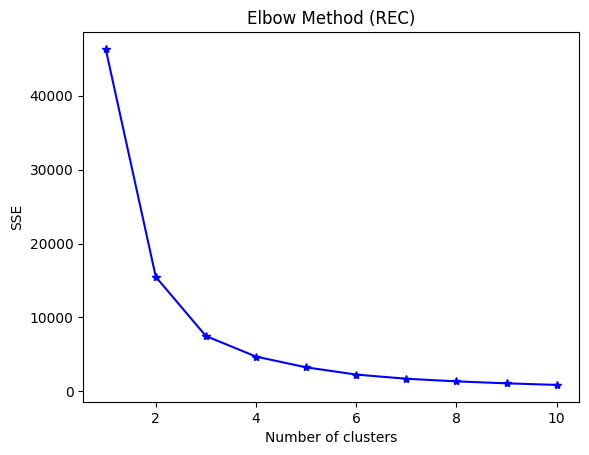

In [55]:
# K-Means Clustering
#k-means
sse=[]
scaler = StandardScaler() 
recency = customer_last_order_timestamp_df1[['RECENCY_DAYS']].to_numpy()
X_scaled = scaler.fit_transform(recency) 

for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, n_init=20, random_state=1)
    kmeans.fit(X_scaled)
    sse.append(kmeans.inertia_)

plt.plot(range(1, 11), sse, 'b-*')
plt.title('Elbow Method (REC)')
plt.xlabel('Number of clusters')
plt.ylabel('SSE')
plt.show()

In [56]:
# Build 3 Recency Clusters and add it to dataframe 
kmeans = KMeans(n_clusters=3, n_init=20, random_state=1)
#tempCustRec = tempCustRec.to_pandas()
kmeans.fit(customer_last_order_timestamp_df1[['RECENCY_DAYS']])
customer_last_order_timestamp_df1['CUST_REC_CLUSTER'] = kmeans.predict(customer_last_order_timestamp_df1[['RECENCY_DAYS']])


#function for ordering cluster numbers

def order_cluster(cluster_field_name, target_field_name,data,ascending):
    new_cluster_field_name = 'new_' + cluster_field_name
    data_new = data.groupby(cluster_field_name)[target_field_name].mean().reset_index()
    data_new = data_new.sort_values(by=target_field_name,ascending=ascending).reset_index(drop=True)
    data_new['index'] = data_new.index
    data_final = pd.merge(data,data_new[[cluster_field_name,'index']], on=cluster_field_name)
    data_final = data_final.drop([cluster_field_name],axis=1)
    data_final = data_final.rename(columns={"index":cluster_field_name})

    return data_final

customer_last_order_timestamp_df1 = order_cluster('CUST_REC_CLUSTER', 'RECENCY_DAYS',customer_last_order_timestamp_df1,False)
#see details of the clusters
customer_last_order_timestamp_df1.groupby('CUST_REC_CLUSTER')['RECENCY_DAYS'].describe()


,count,mean,std,min,25%,50%,75%,max
CUST_REC_CLUSTER,,,,,,,,
0,3542.0,47.166573,12.514456,35.0,38.0,43.0,51.75,148.0
1,12581.0,21.728320,5.669974,14.0,17.0,21.0,26.00,34.0
2,30177.0,4.835537,3.696081,0.0,2.0,4.0,7.00,13.0


In [57]:
customer_last_order_timestamp_df1.head()

,CUSTOMER_ID,TOTAL_SPENT,YEARS_WITH_US,MONETARY_VALUE,CUSTOMER_FREQUENCY,TOTAL_ORDER,RECENCY_DAYS,MAX(DAYS_BETWEEN),MIN(DAYS_BETWEEN),AVG(DAYS_BETWEEN),LAST_ORDER_TS,LAST_TRANS,DAYS_DF1,TRANS_DATEDIFF1,TRANS_DATEDIFF2,CUST_REC_CLUSTER
0,79393,2617.75,3.246575,806.311266,19.405065,63,0,137,1,19.112903,2022-10-04 13:34:14,2022-10-04 22:58:32,0,13,6,2
1,92902,2449.75,3.369863,726.958336,19.288618,65,2,123,1,19.187500,2022-10-02 12:19:11,2022-10-04 22:58:32,2,19,2,2
2,184615,3408.25,3.063014,1112.711205,23.832735,73,0,74,1,15.527778,2022-10-04 18:00:57,2022-10-04 22:58:32,0,5,2,2
3,136558,1945.75,3.380822,575.525715,14.197731,48,2,146,1,26.212766,2022-10-02 19:50:06,2022-10-04 22:58:32,2,58,6,2
4,79903,2831.75,3.490411,811.294143,16.903453,59,7,252,1,21.844828,2022-09-27 20:54:57,2022-10-04 22:58:32,7,12,5,2


##### Frequency

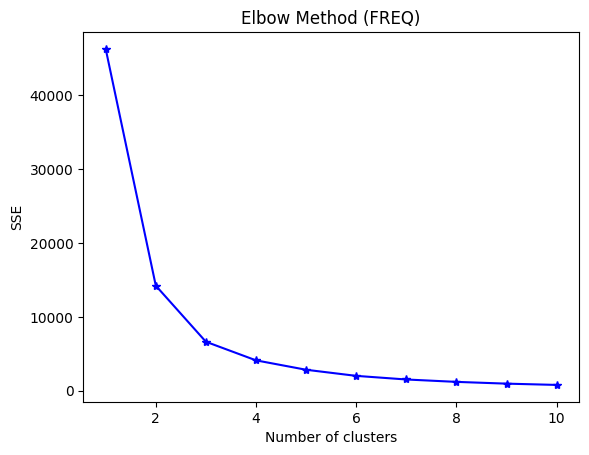

In [58]:
# K-Means Clustering
#k-means
sse=[]
scaler = StandardScaler() 
frequency = customer_last_order_timestamp_df1[['CUSTOMER_FREQUENCY']].to_numpy()
X_scaled = scaler.fit_transform(frequency) 

for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, n_init=20, random_state=1)
    kmeans.fit(X_scaled)
    sse.append(kmeans.inertia_)

plt.plot(range(1, 11), sse, 'b-*')
plt.title('Elbow Method (FREQ)')
plt.xlabel('Number of clusters')
plt.ylabel('SSE')
plt.show()

In [59]:
#build 3 clusters for frequency and add it to dataframe

kmeans = KMeans(n_clusters=3, n_init=20, random_state=1)
kmeans.fit(customer_last_order_timestamp_df1[['CUSTOMER_FREQUENCY']])
customer_last_order_timestamp_df1['CUST_FREQ_CLUSTER'] = kmeans.predict(customer_last_order_timestamp_df1[['CUSTOMER_FREQUENCY']])

# reuse function for ordering cluster numbers
customer_last_order_timestamp_df1 = order_cluster('CUST_FREQ_CLUSTER', 'CUSTOMER_FREQUENCY',customer_last_order_timestamp_df1,True)
#see details of the clusters
customer_last_order_timestamp_df1.groupby('CUST_FREQ_CLUSTER')['CUSTOMER_FREQUENCY'].describe()

,count,mean,std,min,25%,50%,75%,max
CUST_FREQ_CLUSTER,,,,,,,,
0,10709.0,11.655816,1.797355,5.073589,10.354611,11.711228,13.078174,14.789303
1,19930.0,17.929915,1.393061,14.792298,16.887490,18.131428,19.106501,20.034934
2,15661.0,22.154830,1.674573,20.036593,20.839629,21.769387,23.081461,31.660022


In [60]:
customer_last_order_timestamp_df1.head()

,CUSTOMER_ID,TOTAL_SPENT,YEARS_WITH_US,MONETARY_VALUE,CUSTOMER_FREQUENCY,TOTAL_ORDER,RECENCY_DAYS,MAX(DAYS_BETWEEN),MIN(DAYS_BETWEEN),AVG(DAYS_BETWEEN),LAST_ORDER_TS,LAST_TRANS,DAYS_DF1,TRANS_DATEDIFF1,TRANS_DATEDIFF2,CUST_REC_CLUSTER,CUST_FREQ_CLUSTER
0,79393,2617.75,3.246575,806.311266,19.405065,63,0,137,1,19.112903,2022-10-04 13:34:14,2022-10-04 22:58:32,0,13,6,2,1
1,92902,2449.75,3.369863,726.958336,19.288618,65,2,123,1,19.187500,2022-10-02 12:19:11,2022-10-04 22:58:32,2,19,2,2,1
2,79903,2831.75,3.490411,811.294143,16.903453,59,7,252,1,21.844828,2022-09-27 20:54:57,2022-10-04 22:58:32,7,12,5,2,1
3,27004,2427.75,3.454795,702.718975,17.656619,61,2,328,1,20.983333,2022-10-02 15:02:48,2022-10-04 22:58:32,2,10,8,2,1
4,32841,2617.50,3.449315,758.846322,17.974583,62,2,132,1,20.606557,2022-10-02 20:45:57,2022-10-04 22:58:32,2,8,21,2,1


##### Monetary

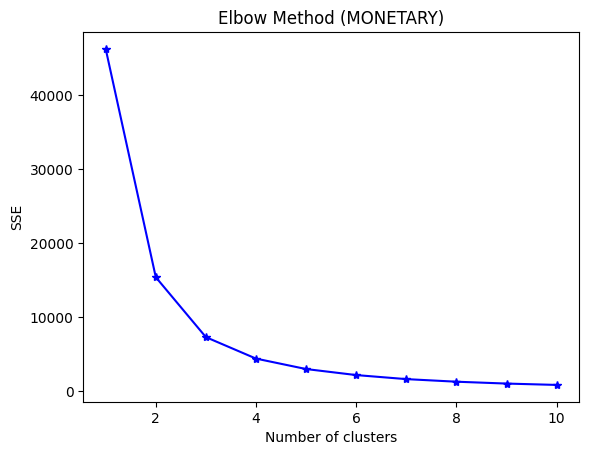

In [61]:
#k-means
sse=[]
scaler = StandardScaler() 
monetary = customer_last_order_timestamp_df1[['MONETARY_VALUE']]
X_scaled = scaler.fit_transform(monetary) 

for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, n_init=20, random_state=1)
    kmeans.fit(X_scaled)
    sse.append(kmeans.inertia_)

plt.plot(range(1, 11), sse, 'b-*')
plt.title('Elbow Method (MONETARY)')
plt.xlabel('Number of clusters')
plt.ylabel('SSE')
plt.show()

In [62]:
#build 3 clusters for monetary and add it to dataframe

kmeans = KMeans(n_clusters=3, n_init=20, random_state=1)
kmeans.fit(customer_last_order_timestamp_df1[['MONETARY_VALUE']])
customer_last_order_timestamp_df1['CUST_MONETARY_CLUSTER'] = kmeans.predict(customer_last_order_timestamp_df1[['MONETARY_VALUE']])


# reuse function for ordering cluster numbers
customer_last_order_timestamp_df1 = order_cluster('CUST_MONETARY_CLUSTER', 'MONETARY_VALUE',customer_last_order_timestamp_df1,True)
customer_last_order_timestamp_df1.groupby("CUST_MONETARY_CLUSTER")["MONETARY_VALUE"].describe()

,count,mean,std,min,25%,50%,75%,max
CUST_MONETARY_CLUSTER,,,,,,,,
0,10983.0,431.262946,79.551180,148.946206,373.506504,434.416247,498.141719,560.176033
1,20714.0,688.828243,62.102331,560.298178,639.842142,695.194373,741.278029,788.083491
2,14603.0,887.114441,80.681557,788.109355,823.471174,868.007731,931.609589,1354.408107


In [63]:
customer_last_order_timestamp_df1.head()

,CUSTOMER_ID,TOTAL_SPENT,YEARS_WITH_US,MONETARY_VALUE,CUSTOMER_FREQUENCY,TOTAL_ORDER,RECENCY_DAYS,MAX(DAYS_BETWEEN),MIN(DAYS_BETWEEN),AVG(DAYS_BETWEEN),LAST_ORDER_TS,LAST_TRANS,DAYS_DF1,TRANS_DATEDIFF1,TRANS_DATEDIFF2,CUST_REC_CLUSTER,CUST_FREQ_CLUSTER,CUST_MONETARY_CLUSTER
0,79393,2617.75,3.246575,806.311266,19.405065,63,0,137,1,19.112903,2022-10-04 13:34:14,2022-10-04 22:58:32,0,13,6,2,1,2
1,79903,2831.75,3.490411,811.294143,16.903453,59,7,252,1,21.844828,2022-09-27 20:54:57,2022-10-04 22:58:32,7,12,5,2,1,2
2,43469,2854.50,3.427397,832.847785,18.964830,65,4,109,1,19.484375,2022-09-30 17:50:19,2022-10-04 22:58:32,4,16,3,2,1,2
3,107834,2531.75,3.189041,793.890703,18.500860,59,5,139,1,19.982759,2022-09-29 21:08:22,2022-10-04 22:58:32,5,24,30,2,1,2
4,40241,2725.75,3.147945,865.882345,19.060053,60,1,169,1,19.457627,2022-10-03 13:22:19,2022-10-04 22:58:32,1,13,7,2,1,2


##### Calculating overall score of customer based on their RFM

In [64]:
# Calculate overall score of customer based on their RFM
customer_last_order_timestamp_df1['OVERALL_SCORE'] = customer_last_order_timestamp_df1['CUST_REC_CLUSTER'] + customer_last_order_timestamp_df1['CUST_FREQ_CLUSTER'] + customer_last_order_timestamp_df1['CUST_MONETARY_CLUSTER']

# Evaluation
customer_last_order_timestamp_df1.groupby('OVERALL_SCORE')[['RECENCY_DAYS','CUSTOMER_FREQUENCY','MONETARY_VALUE']].max()

,RECENCY_DAYS,CUSTOMER_FREQUENCY,MONETARY_VALUE
OVERALL_SCORE,,,
0,148,14.783027,559.854375
1,85,19.406953,727.571040
2,101,20.034934,787.976952
3,84,23.851488,977.298063
4,88,28.214720,1182.799604
5,34,30.591279,1343.779090
6,13,31.660022,1354.408107


In [65]:
customer_last_order_timestamp_df1.head()

,CUSTOMER_ID,TOTAL_SPENT,YEARS_WITH_US,MONETARY_VALUE,CUSTOMER_FREQUENCY,TOTAL_ORDER,RECENCY_DAYS,MAX(DAYS_BETWEEN),MIN(DAYS_BETWEEN),AVG(DAYS_BETWEEN),LAST_ORDER_TS,LAST_TRANS,DAYS_DF1,TRANS_DATEDIFF1,TRANS_DATEDIFF2,CUST_REC_CLUSTER,CUST_FREQ_CLUSTER,CUST_MONETARY_CLUSTER,OVERALL_SCORE
0,79393,2617.75,3.246575,806.311266,19.405065,63,0,137,1,19.112903,2022-10-04 13:34:14,2022-10-04 22:58:32,0,13,6,2,1,2,5
1,79903,2831.75,3.490411,811.294143,16.903453,59,7,252,1,21.844828,2022-09-27 20:54:57,2022-10-04 22:58:32,7,12,5,2,1,2,5
2,43469,2854.50,3.427397,832.847785,18.964830,65,4,109,1,19.484375,2022-09-30 17:50:19,2022-10-04 22:58:32,4,16,3,2,1,2,5
3,107834,2531.75,3.189041,793.890703,18.500860,59,5,139,1,19.982759,2022-09-29 21:08:22,2022-10-04 22:58:32,5,24,30,2,1,2,5
4,40241,2725.75,3.147945,865.882345,19.060053,60,1,169,1,19.457627,2022-10-03 13:22:19,2022-10-04 22:58:32,1,13,7,2,1,2,5


### 4.2 Getting second dataframe <a id="part4.2"></a>

In [66]:
# Get last 2 weeks before last transaction date provided (second dataframe)
order_df2 = order_14days.filter((F.datediff("day", F.col("ORDER_TS"), F.col("LAST_DATE")) >= 14) & (F.datediff("day", F.col("ORDER_TS"), F.col("LAST_DATE")) < 28))
order_df2.show()

----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
|"ORDER_ID"  |"TRUCK_ID"  |"LOCATION_ID"  |"CUSTOMER_ID"  |"DISCOUNT_ID"  |"SHIFT_ID"  |"SHIFT_START_TIME"  |"SHIFT_END_TIME"  |"ORDER_CHANNEL"  |"ORDER_TS"           |"SERVED_TS"  |"ORDER_CURRENCY"  |"ORDER_AMOUNT"  |"ORDER_TAX_AMOUNT"  |"ORDER_DISCOUNT_AMOUNT"  |"ORDER_TOTAL"  |"CUSTOMER_ID_US"  |"LAST_DATE"          |
----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
|456144429   |31          |3218

In [67]:
# Ensure timeframe is correct
order_df2.agg(F.min('ORDER_TS')).show()
order_df2.agg(F.max('ORDER_TS')).show()

-----------------------
|"MIN(ORDER_TS)"      |
-----------------------
|2022-10-05 08:00:56  |
-----------------------

-----------------------
|"MAX(ORDER_TS)"      |
-----------------------
|2022-10-18 22:56:45  |
-----------------------



In [68]:
# Getting the earliest purchase date for each customer in df2
customer_first_order_timestamp_df2 = order_df2.groupBy("CUSTOMER_ID").agg(F.min("ORDER_TS").alias("FIRST_ORDER_TS"))
customer_first_order_timestamp_df2 = customer_first_order_timestamp_df2.sort(col("FIRST_ORDER_TS"))
customer_first_order_timestamp_df2.show()

---------------------------------------
|"CUSTOMER_ID"  |"FIRST_ORDER_TS"     |
---------------------------------------
|128895         |2022-10-05 08:00:56  |
|134784         |2022-10-05 08:01:31  |
|195909         |2022-10-05 08:01:41  |
|37490          |2022-10-05 08:02:00  |
|81752          |2022-10-05 08:02:06  |
|145883         |2022-10-05 08:03:18  |
|148790         |2022-10-05 08:03:25  |
|18706          |2022-10-05 08:03:38  |
|173517         |2022-10-05 08:04:05  |
|91631          |2022-10-05 08:04:06  |
---------------------------------------



In [69]:
# Getting first order date
earliest_transaction_df2 = order_df2.agg(F.min("ORDER_TS").alias("FIRST_ORDER_TS")).collect()[0][0]
customer_first_order_timestamp_df2 = customer_first_order_timestamp_df2.withColumn("FIRST_TRANS", F.iff(F.col("CUSTOMER_ID") == F.col("CUSTOMER_ID"), earliest_transaction_df2, earliest_transaction_df2))
customer_first_order_timestamp_df2.show()

-------------------------------------------------------------
|"CUSTOMER_ID"  |"FIRST_ORDER_TS"     |"FIRST_TRANS"        |
-------------------------------------------------------------
|128895         |2022-10-05 08:00:56  |2022-10-05 08:00:56  |
|134784         |2022-10-05 08:01:31  |2022-10-05 08:00:56  |
|195909         |2022-10-05 08:01:41  |2022-10-05 08:00:56  |
|37490          |2022-10-05 08:02:00  |2022-10-05 08:00:56  |
|81752          |2022-10-05 08:02:06  |2022-10-05 08:00:56  |
|145883         |2022-10-05 08:03:18  |2022-10-05 08:00:56  |
|148790         |2022-10-05 08:03:25  |2022-10-05 08:00:56  |
|18706          |2022-10-05 08:03:38  |2022-10-05 08:00:56  |
|173517         |2022-10-05 08:04:05  |2022-10-05 08:00:56  |
|91631          |2022-10-05 08:04:06  |2022-10-05 08:00:56  |
-------------------------------------------------------------



In [70]:
# Getting the date diff from customer last order to the date 2 weeks before the latest provided transaction date in df1
customer_first_order_timestamp_df2 = customer_first_order_timestamp_df2.withColumn("days_df2", F.datediff("day", customer_first_order_timestamp_df2["FIRST_TRANS"], customer_first_order_timestamp_df2["FIRST_ORDER_TS"]))
customer_first_order_timestamp_df2.show()

--------------------------------------------------------------------------
|"CUSTOMER_ID"  |"FIRST_ORDER_TS"     |"FIRST_TRANS"        |"DAYS_DF2"  |
--------------------------------------------------------------------------
|128895         |2022-10-05 08:00:56  |2022-10-05 08:00:56  |0           |
|134784         |2022-10-05 08:01:31  |2022-10-05 08:00:56  |0           |
|195909         |2022-10-05 08:01:41  |2022-10-05 08:00:56  |0           |
|37490          |2022-10-05 08:02:00  |2022-10-05 08:00:56  |0           |
|81752          |2022-10-05 08:02:06  |2022-10-05 08:00:56  |0           |
|145883         |2022-10-05 08:03:18  |2022-10-05 08:00:56  |0           |
|148790         |2022-10-05 08:03:25  |2022-10-05 08:00:56  |0           |
|18706          |2022-10-05 08:03:38  |2022-10-05 08:00:56  |0           |
|173517         |2022-10-05 08:04:05  |2022-10-05 08:00:56  |0           |
|91631          |2022-10-05 08:04:06  |2022-10-05 08:00:56  |0           |
-------------------------

### 4.3 Merging dataframes <a id="part4.3"></a>

In [71]:
# convert 2nd dataframe to pandas
customer_first_order_timestamp_df2 = customer_first_order_timestamp_df2.to_pandas()

In [72]:
customer_first_order_timestamp_df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32013 entries, 0 to 32012
Data columns (total 4 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   CUSTOMER_ID     32013 non-null  int32         
 1   FIRST_ORDER_TS  32013 non-null  datetime64[ns]
 2   FIRST_TRANS     32013 non-null  datetime64[ns]
 3   DAYS_DF2        32013 non-null  int32         
dtypes: datetime64[ns](2), int32(2)
memory usage: 750.4 KB


In [73]:
customer_last_order_timestamp_df1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 46300 entries, 0 to 46299
Data columns (total 19 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   CUSTOMER_ID            46300 non-null  int32         
 1   TOTAL_SPENT            46300 non-null  float64       
 2   YEARS_WITH_US          46300 non-null  float64       
 3   MONETARY_VALUE         46300 non-null  float64       
 4   CUSTOMER_FREQUENCY     46300 non-null  float64       
 5   TOTAL_ORDER            46300 non-null  int64         
 6   RECENCY_DAYS           46300 non-null  int32         
 7   MAX(DAYS_BETWEEN)      46300 non-null  int32         
 8   MIN(DAYS_BETWEEN)      46300 non-null  int32         
 9   AVG(DAYS_BETWEEN)      46300 non-null  object        
 10  LAST_ORDER_TS          46300 non-null  datetime64[ns]
 11  LAST_TRANS             46300 non-null  datetime64[ns]
 12  DAYS_DF1               46300 non-null  int32         
 13  T

In [74]:
# merge first dataframe and second dataframe 
# since the number of rows in the first and second dataframe are different, we can infer that there are some customers that did not make an order in the 14 days timeframe
final_df = pd.merge(customer_last_order_timestamp_df1, customer_first_order_timestamp_df2, on='CUSTOMER_ID', how='left')

# drop irrelevant columns
final_df = final_df.drop(["FIRST_ORDER_TS", "FIRST_TRANS", "LAST_ORDER_TS", "LAST_TRANS"], axis=1)
final_df.head()


,CUSTOMER_ID,TOTAL_SPENT,YEARS_WITH_US,MONETARY_VALUE,CUSTOMER_FREQUENCY,TOTAL_ORDER,RECENCY_DAYS,MAX(DAYS_BETWEEN),MIN(DAYS_BETWEEN),AVG(DAYS_BETWEEN),DAYS_DF1,TRANS_DATEDIFF1,TRANS_DATEDIFF2,CUST_REC_CLUSTER,CUST_FREQ_CLUSTER,CUST_MONETARY_CLUSTER,OVERALL_SCORE,DAYS_DF2
0,79393,2617.75,3.246575,806.311266,19.405065,63,0,137,1,19.112903,0,13,6,2,1,2,5,6.0
1,79903,2831.75,3.490411,811.294143,16.903453,59,7,252,1,21.844828,7,12,5,2,1,2,5,6.0
2,43469,2854.50,3.427397,832.847785,18.964830,65,4,109,1,19.484375,4,16,3,2,1,2,5,5.0
3,107834,2531.75,3.189041,793.890703,18.500860,59,5,139,1,19.982759,5,24,30,2,1,2,5,5.0
4,40241,2725.75,3.147945,865.882345,19.060053,60,1,169,1,19.457627,1,13,7,2,1,2,5,NaN


### 4.4 Adding Target Variable <a id="part4.4"></a>

In [75]:
final_df["TARGET"] = final_df["DAYS_DF1"] + final_df["DAYS_DF2"]
final_df["TARGET"].fillna(np.floor(final_df["AVG(DAYS_BETWEEN)"]) + final_df["DAYS_DF1"], inplace = True)
final_df = final_df.drop(["DAYS_DF1", "DAYS_DF2"], axis=1)
final_df.head()

,CUSTOMER_ID,TOTAL_SPENT,YEARS_WITH_US,MONETARY_VALUE,CUSTOMER_FREQUENCY,TOTAL_ORDER,RECENCY_DAYS,MAX(DAYS_BETWEEN),MIN(DAYS_BETWEEN),AVG(DAYS_BETWEEN),TRANS_DATEDIFF1,TRANS_DATEDIFF2,CUST_REC_CLUSTER,CUST_FREQ_CLUSTER,CUST_MONETARY_CLUSTER,OVERALL_SCORE,TARGET
0,79393,2617.75,3.246575,806.311266,19.405065,63,0,137,1,19.112903,13,6,2,1,2,5,6.0
1,79903,2831.75,3.490411,811.294143,16.903453,59,7,252,1,21.844828,12,5,2,1,2,5,13.0
2,43469,2854.50,3.427397,832.847785,18.964830,65,4,109,1,19.484375,16,3,2,1,2,5,9.0
3,107834,2531.75,3.189041,793.890703,18.500860,59,5,139,1,19.982759,24,30,2,1,2,5,10.0
4,40241,2725.75,3.147945,865.882345,19.060053,60,1,169,1,19.457627,13,7,2,1,2,5,20.0


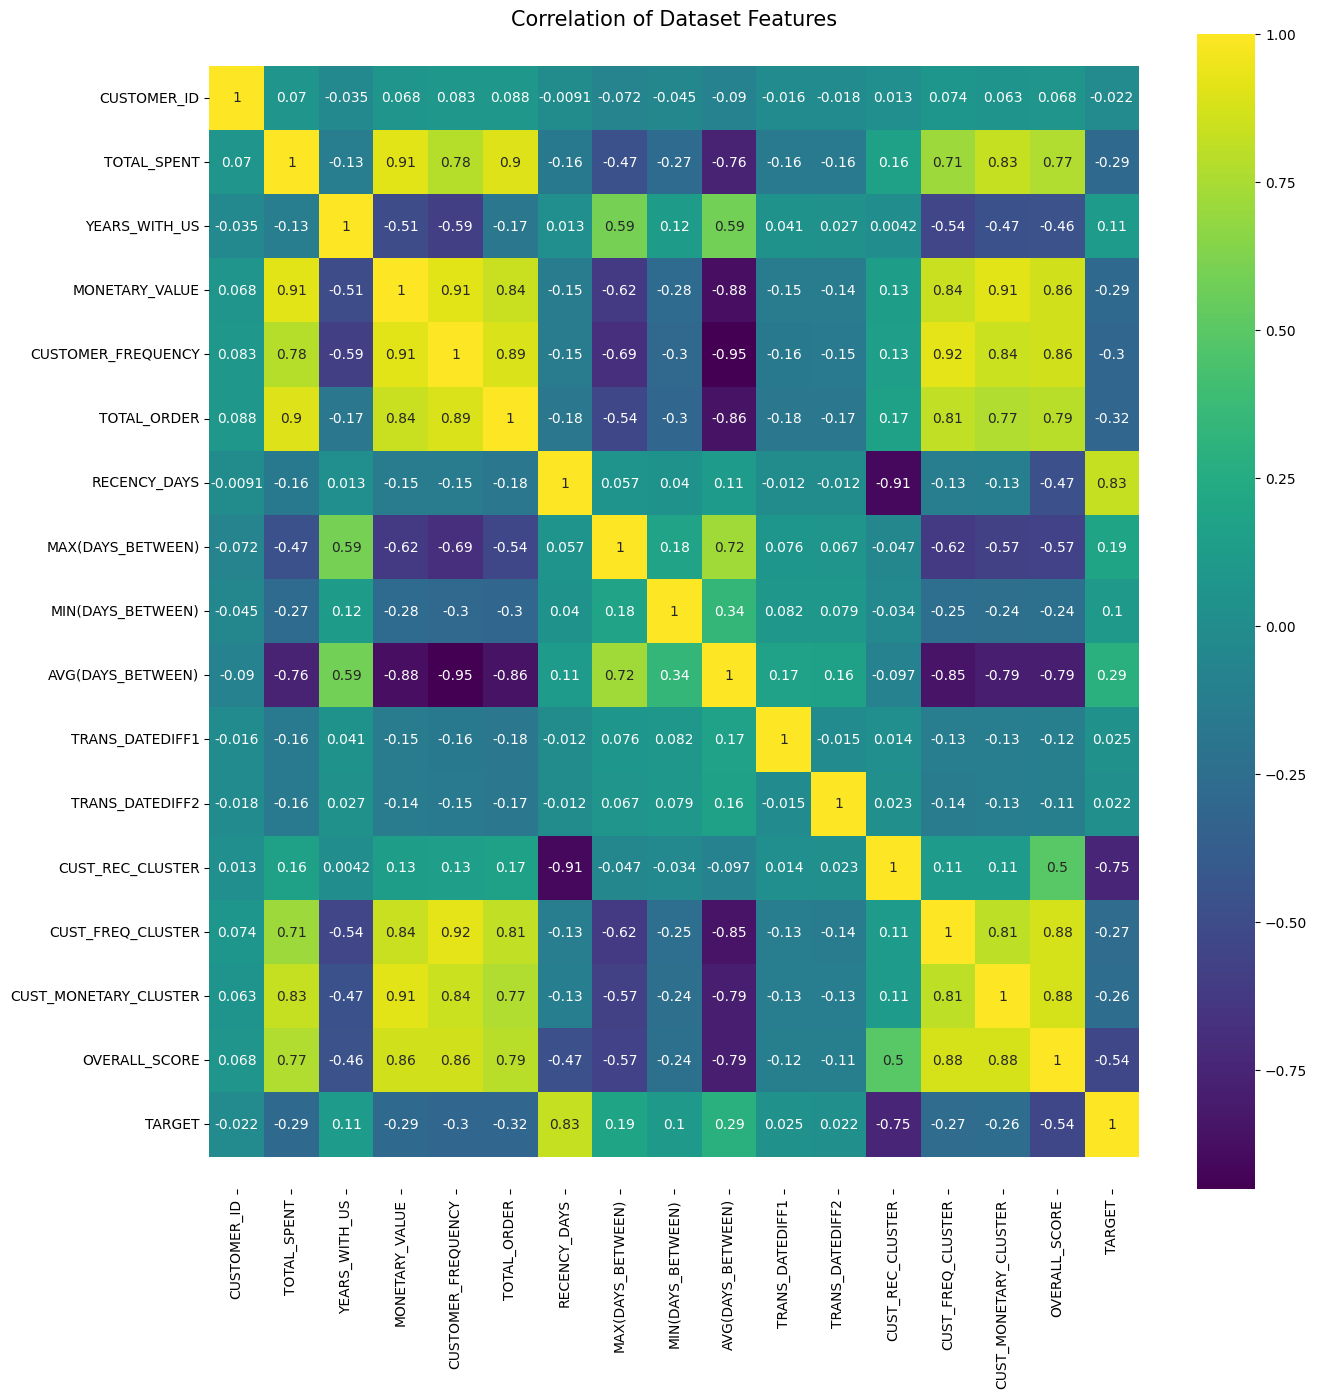

In [76]:
colormap = plt.cm.viridis
plt.figure(figsize=(15,15))
plt.title('Correlation of Dataset Features', size=15)
ax = sns.heatmap(final_df.astype(float).corr(), cmap=colormap, annot=True)
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)
plt.show()

## 5. Model Building <a id="part5"></a>

### 5.1 Scaling <a id="part5.1"></a>

In [77]:
# save dataframe of customer_id 
customer_id_df = final_df["CUSTOMER_ID"]

final_df = final_df.drop(["CUSTOMER_ID"],  axis = 1)

final_df.head()

,TOTAL_SPENT,YEARS_WITH_US,MONETARY_VALUE,CUSTOMER_FREQUENCY,TOTAL_ORDER,RECENCY_DAYS,MAX(DAYS_BETWEEN),MIN(DAYS_BETWEEN),AVG(DAYS_BETWEEN),TRANS_DATEDIFF1,TRANS_DATEDIFF2,CUST_REC_CLUSTER,CUST_FREQ_CLUSTER,CUST_MONETARY_CLUSTER,OVERALL_SCORE,TARGET
0,2617.75,3.246575,806.311266,19.405065,63,0,137,1,19.112903,13,6,2,1,2,5,6.0
1,2831.75,3.490411,811.294143,16.903453,59,7,252,1,21.844828,12,5,2,1,2,5,13.0
2,2854.50,3.427397,832.847785,18.964830,65,4,109,1,19.484375,16,3,2,1,2,5,9.0
3,2531.75,3.189041,793.890703,18.500860,59,5,139,1,19.982759,24,30,2,1,2,5,10.0
4,2725.75,3.147945,865.882345,19.060053,60,1,169,1,19.457627,13,7,2,1,2,5,20.0


In [78]:
# Drop target
target = final_df['TARGET']
final_df.drop('TARGET', axis = 1, inplace = True)

scaler = StandardScaler()
scaler.fit(final_df)

final_scaled = scaler.transform(final_df)
final_scaled = pd.DataFrame(final_scaled, columns=final_df.columns)

#assign target variable back to scaled data frame
final_scaled = final_scaled.assign(TARGET = target)

final_scaled.head()

,TOTAL_SPENT,YEARS_WITH_US,MONETARY_VALUE,CUSTOMER_FREQUENCY,TOTAL_ORDER,RECENCY_DAYS,MAX(DAYS_BETWEEN),MIN(DAYS_BETWEEN),AVG(DAYS_BETWEEN),TRANS_DATEDIFF1,TRANS_DATEDIFF2,CUST_REC_CLUSTER,CUST_FREQ_CLUSTER,CUST_MONETARY_CLUSTER,OVERALL_SCORE,TARGET
0,1.282426,0.897844,0.634812,0.356154,1.063874,-0.936277,0.109877,-0.266625,-0.436691,-0.040053,-0.598736,0.673804,-0.143166,1.246948,0.767572,6.0
1,1.726643,1.618783,0.662071,-0.238912,0.681788,-0.418758,1.744459,-0.266625,-0.032211,-0.117173,-0.674160,0.673804,-0.143166,1.246948,0.767572,13.0
2,1.773867,1.432473,0.779982,0.251434,1.254917,-0.640552,-0.288109,-0.266625,-0.381692,0.191308,-0.825007,0.673804,-0.143166,1.246948,0.767572,9.0
3,1.103909,0.727736,0.566865,0.141068,0.681788,-0.566621,0.138304,-0.266625,-0.307903,0.808270,1.211430,0.673804,-0.143166,1.246948,0.767572,10.0
4,1.506610,0.606229,0.960699,0.274085,0.777310,-0.862346,0.564717,-0.266625,-0.385652,-0.040053,-0.523313,0.673804,-0.143166,1.246948,0.767572,20.0


### 5.2 Train Test Split <a id="part5.2"></a>

In [79]:
# Define ratio for model 
train_ratio = 0.70
test_ratio = 0.30

# Define Model Inputs (X) and Output (y)
X = final_scaled.drop('TARGET',axis=1)
y = final_scaled["TARGET"]

# Split both Inputs (X) and Ouput (y) into training set (70%) and testing set (20%)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_ratio, random_state=1)


In [80]:
modelTestResults = pd.DataFrame(columns=['Model', 'Train_MSE', 'Test_MSE', 'Train_R^2', 'Test_R^2', 'Cross_Val_Train_MSE','Cross_Val_Test_MSE'])

### 5.3 Linear Regression <a id="part5.3"></a>

In [81]:
# Create the model "lg"
lg = LinearRegression()
lg.fit(X_train, y_train)

#MSE

train_mse = mean_squared_error(lg.predict(X_train), y_train)
print('The Training Mean Squared Error for Linear Regression Model is: ', train_mse)
test_mse = mean_squared_error(lg.predict(X_test), y_test)
print('The Testing Mean Squared Error for Linear Regression Model is: ',test_mse)

print('')

#R^2

train_R2 = lg.score(X_train, y_train)
print('The Training R^2 for Linear Regression Model is: ', train_R2)

test_R2 = lg.score(X_test, y_test)
print('The Testing R^2 for Linear Regression Model is: ', test_R2)

# Define the new row to be added
new_row = {'Model' : 'Linear Regression','Train_MSE': train_mse, 'Test_MSE': test_mse, 'Train_R^2': train_R2, 'Test_R^2': test_R2}
# Use the loc method to add the new row to the DataFrame
modelTestResults.loc[len(modelTestResults)] = new_row

The Training Mean Squared Error for Linear Regression Model is:  80.16973960886162
The Testing Mean Squared Error for Linear Regression Model is:  81.33303677362905

The Training R^2 for Linear Regression Model is:  0.718540043267542
The Testing R^2 for Linear Regression Model is:  0.7264031160954967


### 5.4 Decision Tree <a id="part5.4"></a>

In [82]:
dt = tree.DecisionTreeRegressor(max_depth=2, random_state=1)
dt.fit(X_train, y_train)

#MSE

train_mse = mean_squared_error(dt.predict(X_train), y_train)
print('The Training Mean Squared Error for Decision Tree Regressor Model is: ', train_mse)
test_mse = mean_squared_error(dt.predict(X_test), y_test)
print('The Testing Mean Squared Error for Decision Tree Regressor Model is: ',test_mse)

print('')

#R^2

train_R2 = dt.score(X_train, y_train)
print('The Training R^2 for Decision Tree Regressor Model is: ', train_R2)

test_R2 = dt.score(X_test, y_test)
print('The Testing R^2 for Decision Tree Regressor is: ', test_R2)

The Training Mean Squared Error for Decision Tree Regressor Model is:  109.27198376255633
The Testing Mean Squared Error for Decision Tree Regressor Model is:  111.7820130236825

The Training R^2 for Decision Tree Regressor Model is:  0.6163678718188158
The Testing R^2 for Decision Tree Regressor is:  0.6239755497514108


In [83]:
# Evaluate the Model using K-folds Cross validation
results = cross_validate(dt, X, y, scoring='neg_mean_squared_error', cv=5, return_train_score = True)
print('train_score: ', results['train_score'])
print('test_score: ', results['test_score'])

cv_train_accuracy = sum(-results['train_score'])/len(results['train_score'])
cv_test_accuracy = sum(-results['test_score'])/len(results['test_score'])
print('cross val training mse is:', sum(-results['train_score'])/len(results['train_score']))
print('cross val testing mse is:', sum(-results['test_score'])/len(results['test_score']))

# Define the new row to be added
new_row = {'Model' : 'Decision Tree','Train_MSE': train_mse, 'Test_MSE': test_mse, 'Train_R^2': train_R2, 'Test_R^2': test_R2, 'Cross_Val_Train_MSE': cv_train_accuracy,'Cross_Val_Test_MSE': cv_test_accuracy}
# Use the loc method to add the new row to the DataFrame
modelTestResults.loc[len(modelTestResults)] = new_row

train_score:  [-123.04680463 -121.32707611 -119.46280641 -118.2284672   -67.93279166]
test_score:  [ -59.72019264  -66.15142904  -73.07797939 -103.3128947  -316.20909424]
cross val training mse is: 109.99958920343067
cross val testing mse is: 123.6943180015764


#### 5.8 XGBoost Model <a id="part5-8"></a>

In [84]:
# Create an instance of the model
xgb = XGBRegressor()

# Fit the XGBClassifier to the training data
xgb.fit(X_train,y_train.ravel())

#MSE

train_mse = mean_squared_error(xgb.predict(X_train), y_train)
print('The Training Mean Squared Error for XGBoost is: ', train_mse)
test_mse = mean_squared_error(xgb.predict(X_test), y_test)
print('The Testing Mean Squared Error for XGBoost is: ',test_mse)

print('')

#R^2

train_R2 = xgb.score(X_train, y_train)
print('The Training R^2 for XGBoost is: ', train_R2)

test_R2 = xgb.score(X_test, y_test)
print('The Testing R^2 for XGBoost is: ', test_R2)

The Training Mean Squared Error for XGBoost is:  51.25241820613287
The Testing Mean Squared Error for XGBoost is:  88.25157885682344

The Training R^2 for XGBoost is:  0.8200629878416436
The Testing R^2 for XGBoost is:  0.7031297744103391


In [85]:
# Evaluate the Model using K-folds Cross validation
results = cross_validate(xgb, X, y, scoring='neg_mean_squared_error', cv=5, return_train_score = True)
print('train_score: ', results['train_score'])
print('test_score: ', results['test_score'])

cv_train_accuracy = sum(-results['train_score'])/len(results['train_score'])
cv_test_accuracy = sum(-results['test_score'])/len(results['test_score'])
print('cross val training accuracy is:', sum(-results['train_score'])/len(results['train_score']))
print('cross val testing accuracy is:', sum(-results['test_score'])/len(results['test_score']))

# Define the new row to be added
new_row = {'Model' : 'XGBoost','Train_MSE': train_mse, 'Test_MSE': test_mse, 'Train_R^2': train_R2, 'Test_R^2': test_R2, 'Cross_Val_Train_MSE': cv_train_accuracy,'Cross_Val_Test_MSE': cv_test_accuracy}
# Use the loc method to add the new row to the DataFrame
modelTestResults.loc[len(modelTestResults)] = new_row

train_score:  [-61.0024611  -59.74440404 -56.0861265  -56.14121074 -38.34717658]
test_score:  [ -41.99216056  -46.04583022  -59.39702429  -67.10662303 -239.88740244]
cross val training accuracy is: 54.264275791187
cross val testing accuracy is: 90.8858081083012


#### 5.9 ADA Boost Model <a id="part5-9"></a>

In [86]:
# Create an instance of the model
ada = AdaBoostRegressor()

# Fit the XGBClassifier to the training data
ada.fit(X_train,y_train)

#MSE

train_mse = mean_squared_error(ada.predict(X_train), y_train)
print('The Training Mean Squared Error for ADA Boost is: ', train_mse)
test_mse = mean_squared_error(ada.predict(X_test), y_test)
print('The Testing Mean Squared Error for ADA Boost is: ',test_mse)

print('')

#R^2

train_R2 = ada.score(X_train, y_train)
print('The Training R^2 for ADA Boost is: ', train_R2)

test_R2 = ada.score(X_test, y_test)
print('The Testing R^2 for ADA Boost is: ', test_R2)

The Training Mean Squared Error for ADA Boost is:  88.79348309105784
The Testing Mean Squared Error for ADA Boost is:  90.56525151875377

The Training R^2 for ADA Boost is:  0.6882638008946347
The Testing R^2 for ADA Boost is:  0.6953467915562619


In [87]:
# Evaluate the Model using K-folds Cross validation
results = cross_validate(ada, X, y, scoring='neg_mean_squared_error', cv=5, return_train_score = True)
print('train_score: ', results['train_score'])
print('test_score: ', results['test_score'])

cv_train_accuracy = sum(-results['train_score'])/len(results['train_score'])
cv_test_accuracy = sum(-results['test_score'])/len(results['test_score'])
print('cross val training accuracy is:', sum(-results['train_score'])/len(results['train_score']))
print('cross val testing accuracy is:', sum(-results['test_score'])/len(results['test_score']))

# Define the new row to be added
new_row = {'Model' : 'ADA Boost','Train_MSE': train_mse, 'Test_MSE': test_mse, 'Train_R^2': train_R2, 'Test_R^2': test_R2, 'Cross_Val_Train_MSE': cv_train_accuracy,'Cross_Val_Test_MSE': cv_test_accuracy}
# Use the loc method to add the new row to the DataFrame
modelTestResults.loc[len(modelTestResults)] = new_row

train_score:  [-104.684716   -100.41471494 -101.09410383  -93.98915695  -55.07022636]
test_score:  [ -63.38772452  -61.17157411  -74.08547436  -78.53459642 -211.45635619]
cross val training accuracy is: 91.0505836155248
cross val testing accuracy is: 97.72714512055829


In [88]:
# Dataframe for accuracy of each model
modelTestResults

,Model,Train_MSE,Test_MSE,Train_R^2,Test_R^2,Cross_Val_Train_MSE,Cross_Val_Test_MSE
0,Linear Regression,80.169740,81.333037,0.718540,0.726403,NaN,NaN
1,Decision Tree,109.271984,111.782013,0.616368,0.623976,109.999589,123.694318
2,XGBoost,51.252418,88.251579,0.820063,0.703130,54.264276,90.885808
3,ADA Boost,88.793483,90.565252,0.688264,0.695347,91.050584,97.727145


## 6. Holdout Data <a id="part6"></a>
Repeating all the above steps for new timeframe

In [89]:
order_header_df.agg(F.min('ORDER_TS')).show()
order_header_df.agg(F.max('ORDER_TS')).show()

-----------------------
|"MIN(ORDER_TS)"      |
-----------------------
|2019-01-01 17:19:08  |
-----------------------

-----------------------
|"MAX(ORDER_TS)"      |
-----------------------
|2022-11-01 22:58:56  |
-----------------------



In [90]:
# Get data till 2 weeks before last transaction date provided (first dataframe)
order_df1_holdout = order_header_df.filter(F.datediff("day", F.col("ORDER_TS"), F.col("LAST_DATE")) >= 14)
order_df1_holdout.show()

----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
|"ORDER_ID"  |"TRUCK_ID"  |"LOCATION_ID"  |"CUSTOMER_ID"  |"DISCOUNT_ID"  |"SHIFT_ID"  |"SHIFT_START_TIME"  |"SHIFT_END_TIME"  |"ORDER_CHANNEL"  |"ORDER_TS"           |"SERVED_TS"  |"ORDER_CURRENCY"  |"ORDER_AMOUNT"  |"ORDER_TAX_AMOUNT"  |"ORDER_DISCOUNT_AMOUNT"  |"ORDER_TOTAL"  |"CUSTOMER_ID_US"  |"LAST_DATE"          |
----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
|451449961   |17          |1789

In [91]:
# Ensure timeframe is correct
order_df1_holdout.agg(F.min('ORDER_TS')).show()
order_df1_holdout.agg(F.max('ORDER_TS')).show()

-----------------------
|"MIN(ORDER_TS)"      |
-----------------------
|2019-01-01 17:19:08  |
-----------------------

-----------------------
|"MAX(ORDER_TS)"      |
-----------------------
|2022-10-18 22:56:45  |
-----------------------



In [92]:
# Getting the latest purchase date for each customer in df1_holdout
customer_last_order_timestamp_df1_holdout = order_df1_holdout.groupBy("CUSTOMER_ID").agg(F.max("ORDER_TS").alias("LAST_ORDER_TS"))
customer_last_order_timestamp_df1_holdout.show()

---------------------------------------
|"CUSTOMER_ID"  |"LAST_ORDER_TS"      |
---------------------------------------
|99391          |2022-10-07 21:36:00  |
|144918         |2022-10-16 19:55:10  |
|45565          |2022-10-10 22:55:54  |
|182107         |2022-10-13 19:57:09  |
|57719          |2022-10-14 18:40:31  |
|15141          |2022-09-27 17:59:27  |
|33489          |2022-10-06 11:17:29  |
|154145         |2022-10-09 13:38:00  |
|31507          |2022-10-01 19:16:01  |
|71691          |2022-10-01 14:08:42  |
---------------------------------------



In [93]:
# Getting last order date
lastest_transaction_df1_holdout = order_df1_holdout.agg(F.max("ORDER_TS").alias("LAST_ORDER_TS")).collect()[0][0]
customer_last_order_timestamp_df1_holdout = customer_last_order_timestamp_df1_holdout.withColumn("LAST_TRANS", F.iff(F.col("CUSTOMER_ID") == F.col("CUSTOMER_ID"), lastest_transaction_df1_holdout, lastest_transaction_df1_holdout))
customer_last_order_timestamp_df1_holdout.show()

-------------------------------------------------------------
|"CUSTOMER_ID"  |"LAST_ORDER_TS"      |"LAST_TRANS"         |
-------------------------------------------------------------
|23949          |2022-10-16 17:28:07  |2022-10-18 22:56:45  |
|27971          |2022-09-19 18:04:51  |2022-10-18 22:56:45  |
|193091         |2022-10-09 08:32:51  |2022-10-18 22:56:45  |
|187890         |2022-10-08 09:50:11  |2022-10-18 22:56:45  |
|44825          |2022-10-06 12:12:41  |2022-10-18 22:56:45  |
|88758          |2022-09-21 19:24:40  |2022-10-18 22:56:45  |
|145672         |2022-10-02 20:38:34  |2022-10-18 22:56:45  |
|158649         |2022-10-11 14:41:37  |2022-10-18 22:56:45  |
|92481          |2022-10-06 21:07:37  |2022-10-18 22:56:45  |
|97283          |2022-10-09 09:47:55  |2022-10-18 22:56:45  |
-------------------------------------------------------------



In [94]:
# Getting the date diff from customer last order to the date 2 weeks before the latest provided transaction date in df1
customer_last_order_timestamp_df1_holdout = customer_last_order_timestamp_df1_holdout.withColumn("days_df1", F.datediff("day", customer_last_order_timestamp_df1_holdout["LAST_ORDER_TS"], customer_last_order_timestamp_df1_holdout["LAST_TRANS"]))
customer_last_order_timestamp_df1_holdout.show()

--------------------------------------------------------------------------
|"CUSTOMER_ID"  |"LAST_ORDER_TS"      |"LAST_TRANS"         |"DAYS_DF1"  |
--------------------------------------------------------------------------
|192452         |2022-10-16 11:35:10  |2022-10-18 22:56:45  |2           |
|22386          |2022-10-09 16:33:19  |2022-10-18 22:56:45  |9           |
|89114          |2022-10-14 08:35:48  |2022-10-18 22:56:45  |4           |
|15039          |2022-10-15 20:11:25  |2022-10-18 22:56:45  |3           |
|159198         |2022-10-14 11:15:21  |2022-10-18 22:56:45  |4           |
|84323          |2022-10-07 19:08:26  |2022-10-18 22:56:45  |11          |
|65661          |2022-10-14 11:19:17  |2022-10-18 22:56:45  |4           |
|187032         |2022-10-08 17:42:15  |2022-10-18 22:56:45  |10          |
|93249          |2022-10-10 09:09:07  |2022-10-18 22:56:45  |8           |
|55022          |2022-10-06 08:07:21  |2022-10-18 22:56:45  |12          |
-------------------------

In [95]:
# create a dataframe with customer id and order datetime
cust_order_dates_holdout = order_df1_holdout.sort("CUSTOMER_ID")
cust_order_dates_holdout = cust_order_dates_holdout.select("CUSTOMER_ID", "ORDER_TS")
cust_order_dates_holdout.show()

---------------------------------------
|"CUSTOMER_ID"  |"ORDER_TS"           |
---------------------------------------
|22             |2019-05-31 18:15:35  |
|22             |2019-05-15 21:36:14  |
|22             |2021-01-19 10:58:41  |
|22             |2020-03-16 09:57:28  |
|22             |2020-08-20 19:20:25  |
|22             |2021-02-27 20:28:29  |
|22             |2020-07-25 11:26:41  |
|22             |2020-07-29 19:11:27  |
|22             |2020-10-18 18:21:23  |
|22             |2019-11-20 17:29:15  |
---------------------------------------



In [96]:
# extract the date from the datetime
cust_order_dates_holdout = cust_order_dates_holdout.withColumn('ORDER_DATE', to_date(col('ORDER_TS')))
cust_order_dates_holdout = cust_order_dates_holdout.drop("ORDER_TS")
cust_order_dates_holdout.show()

--------------------------------
|"CUSTOMER_ID"  |"ORDER_DATE"  |
--------------------------------
|22             |2022-07-02    |
|22             |2022-09-07    |
|22             |2022-10-06    |
|22             |2022-09-14    |
|22             |2022-08-24    |
|22             |2022-10-08    |
|22             |2022-06-11    |
|22             |2022-08-02    |
|22             |2022-09-29    |
|22             |2022-05-15    |
--------------------------------



In [97]:
# drop duplicate rows --> some customers may make multiple transactions in a day
cust_order_dates_holdout = cust_order_dates_holdout.dropDuplicates()
cust_order_dates_holdout.show()

--------------------------------
|"CUSTOMER_ID"  |"ORDER_DATE"  |
--------------------------------
|69616          |2020-01-23    |
|69624          |2022-02-20    |
|69632          |2022-09-15    |
|69624          |2020-05-14    |
|69627          |2022-03-01    |
|69633          |2021-10-22    |
|69626          |2020-05-22    |
|69651          |2021-11-17    |
|69651          |2022-02-12    |
|69680          |2020-12-30    |
--------------------------------



In [98]:
# sort the order date by chronological order and by customer id
cust_order_dates_holdout = cust_order_dates_holdout.sort(["CUSTOMER_ID", col("ORDER_DATE").desc()])
cust_order_dates_holdout.show()

--------------------------------
|"CUSTOMER_ID"  |"ORDER_DATE"  |
--------------------------------
|22             |2022-10-17    |
|22             |2022-10-15    |
|22             |2022-10-08    |
|22             |2022-10-06    |
|22             |2022-09-29    |
|22             |2022-09-14    |
|22             |2022-09-07    |
|22             |2022-08-24    |
|22             |2022-08-02    |
|22             |2022-07-02    |
--------------------------------



In [99]:
# find out which customers have less than 3 transactions made on different days
cust_order_dates_holdout.groupBy("CUSTOMER_ID").count().filter(col("COUNT") < 3).show()

---------------------------
|"CUSTOMER_ID"  |"COUNT"  |
---------------------------
|               |         |
---------------------------



In [100]:
# since no customers have less than 3 transactions made on different days, get the dates of the last 3 transactions of each customer

# partition the data by customer id and order it by descending order of the date 
partition = Window.partitionBy("CUSTOMER_ID").orderBy(col("ORDER_DATE").desc)

# using lag, get the previous 2 dates and place it into a new column 
cust_order_dates_holdout = cust_order_dates_holdout.withColumn("ORDER_DATE_2", F.lag(col("ORDER_DATE"), 1).over(Window.partitionBy("CUSTOMER_ID").orderBy(desc("ORDER_DATE"))))
cust_order_dates_holdout = cust_order_dates_holdout.withColumn("ORDER_DATE_3", F.lag(col("ORDER_DATE"), 2).over(Window.partitionBy("CUSTOMER_ID").orderBy(desc("ORDER_DATE"))))

cust_order_dates_holdout.show()

------------------------------------------------------------------
|"CUSTOMER_ID"  |"ORDER_DATE"  |"ORDER_DATE_2"  |"ORDER_DATE_3"  |
------------------------------------------------------------------
|22             |2022-10-17    |NULL            |NULL            |
|22             |2022-10-15    |2022-10-17      |NULL            |
|22             |2022-10-08    |2022-10-15      |2022-10-17      |
|22             |2022-10-06    |2022-10-08      |2022-10-15      |
|22             |2022-09-29    |2022-10-06      |2022-10-08      |
|22             |2022-09-14    |2022-09-29      |2022-10-06      |
|22             |2022-09-07    |2022-09-14      |2022-09-29      |
|22             |2022-08-24    |2022-09-07      |2022-09-14      |
|22             |2022-08-02    |2022-08-24      |2022-09-07      |
|22             |2022-07-02    |2022-08-02      |2022-08-24      |
------------------------------------------------------------------



In [101]:
# drop rows with null
cust_order_dates_holdout = cust_order_dates_holdout.dropna()
cust_order_dates_holdout.show()

------------------------------------------------------------------
|"CUSTOMER_ID"  |"ORDER_DATE"  |"ORDER_DATE_2"  |"ORDER_DATE_3"  |
------------------------------------------------------------------
|43161          |2021-09-01    |2021-09-11      |2021-09-30      |
|43161          |2021-06-14    |2021-09-01      |2021-09-11      |
|43161          |2021-06-05    |2021-06-14      |2021-09-01      |
|43161          |2021-05-20    |2021-06-05      |2021-06-14      |
|43161          |2021-03-31    |2021-05-20      |2021-06-05      |
|43161          |2021-03-27    |2021-03-31      |2021-05-20      |
|43161          |2021-02-08    |2021-03-27      |2021-03-31      |
|43161          |2021-02-04    |2021-02-08      |2021-03-27      |
|43161          |2021-01-29    |2021-02-04      |2021-02-08      |
|43161          |2021-01-27    |2021-01-29      |2021-02-04      |
------------------------------------------------------------------



In [102]:
# choose only the top row for each customer id and put it into a new dataframe
windowSpec = Window.partitionBy("CUSTOMER_ID").orderBy(desc("ORDER_DATE"))

past3_trans_holdout = cust_order_dates_holdout.withColumn("row_number", row_number().over(windowSpec)).filter(col("row_number") == 1).drop("row_number")

past3_trans_holdout.show()

------------------------------------------------------------------
|"CUSTOMER_ID"  |"ORDER_DATE"  |"ORDER_DATE_2"  |"ORDER_DATE_3"  |
------------------------------------------------------------------
|67321          |2022-09-11    |2022-09-16      |2022-10-12      |
|101268         |2022-07-25    |2022-08-15      |2022-10-03      |
|154673         |2022-08-24    |2022-09-15      |2022-10-08      |
|111520         |2022-09-18    |2022-09-24      |2022-09-30      |
|126813         |2022-08-29    |2022-09-01      |2022-10-07      |
|32865          |2022-09-19    |2022-10-03      |2022-10-07      |
|28579          |2022-09-10    |2022-09-28      |2022-10-16      |
|105803         |2022-09-05    |2022-09-16      |2022-10-02      |
|160121         |2022-06-30    |2022-07-01      |2022-09-07      |
|187906         |2022-09-30    |2022-10-01      |2022-10-06      |
------------------------------------------------------------------



In [103]:
# calculate the date difference between each order date
past3_trans_holdout = past3_trans_holdout.withColumn("TRANS_DATEDIFF1", F.datediff("day", past3_trans_holdout["ORDER_DATE"], past3_trans_holdout["ORDER_DATE_2"]))
past3_trans_holdout = past3_trans_holdout.withColumn("TRANS_DATEDIFF2", F.datediff("day", past3_trans_holdout["ORDER_DATE_2"], past3_trans_holdout["ORDER_DATE_3"]))

past3_trans_holdout.show()

----------------------------------------------------------------------------------------------------------
|"CUSTOMER_ID"  |"ORDER_DATE"  |"ORDER_DATE_2"  |"ORDER_DATE_3"  |"TRANS_DATEDIFF1"  |"TRANS_DATEDIFF2"  |
----------------------------------------------------------------------------------------------------------
|67321          |2022-09-11    |2022-09-16      |2022-10-12      |5                  |26                 |
|101268         |2022-07-25    |2022-08-15      |2022-10-03      |21                 |49                 |
|154673         |2022-08-24    |2022-09-15      |2022-10-08      |22                 |23                 |
|111520         |2022-09-18    |2022-09-24      |2022-09-30      |6                  |6                  |
|126813         |2022-08-29    |2022-09-01      |2022-10-07      |3                  |36                 |
|32865          |2022-09-19    |2022-10-03      |2022-10-07      |14                 |4                  |
|34166          |2022-09-28    |2022-

In [104]:
# merge the dataframe with the past 3 transactions with the first dataframe

past3_trans_holdout = past3_trans_holdout.select("CUSTOMER_ID", "TRANS_DATEDIFF1", "TRANS_DATEDIFF2")

customer_last_order_timestamp_df1_holdout = customer_last_order_timestamp_df1_holdout.join(past3_trans_holdout, 
                                customer_last_order_timestamp_df1_holdout.CUSTOMER_ID==past3_trans_holdout.CUSTOMER_ID, lsuffix="", rsuffix="_PAST3_TRANS")

customer_last_order_timestamp_df1_holdout = customer_last_order_timestamp_df1_holdout.drop("CUSTOMER_ID_PAST3_TRANS")

customer_last_order_timestamp_df1_holdout.show()

------------------------------------------------------------------------------------------------------------------
|"CUSTOMER_ID"  |"LAST_ORDER_TS"      |"LAST_TRANS"         |"DAYS_DF1"  |"TRANS_DATEDIFF1"  |"TRANS_DATEDIFF2"  |
------------------------------------------------------------------------------------------------------------------
|178419         |2022-10-18 16:28:53  |2022-10-18 22:56:45  |0           |20                 |17                 |
|178422         |2022-10-06 19:33:39  |2022-10-18 22:56:45  |12          |7                  |2                  |
|178424         |2022-10-16 12:35:43  |2022-10-18 22:56:45  |2           |2                  |22                 |
|178426         |2022-09-29 17:18:43  |2022-10-18 22:56:45  |19          |1                  |23                 |
|178428         |2022-10-18 08:29:13  |2022-10-18 22:56:45  |0           |11                 |42                 |
|178432         |2022-09-22 16:25:35  |2022-10-18 22:56:45  |26          |7     

In [105]:
# Finding the average days between purchase for each customer
customer_order_times_holdout = order_df1_holdout.sort(col("CUSTOMER_ID"), col("ORDER_TS"))
customer_order_times_holdout = customer_order_times_holdout.withColumn("prev_order_date", F.lag(col("ORDER_TS"), 1).over(Window.partitionBy("CUSTOMER_ID").orderBy("ORDER_TS"))).withColumn("days_between", F.datediff('day', col("prev_order_date"), col("ORDER_TS")))
customer_average_days_holdout = customer_order_times_holdout.groupBy("CUSTOMER_ID").avg("days_between")
customer_average_days_holdout = customer_average_days_holdout.sort(col('CUSTOMER_ID'))
customer_average_days_holdout.show()

---------------------------------------
|"CUSTOMER_ID"  |"AVG(DAYS_BETWEEN)"  |
---------------------------------------
|22             |29.785714            |
|42             |33.864865            |
|59             |33.486486            |
|65             |29.095238            |
|106            |23.765957            |
|118            |29.540541            |
|166            |19.214286            |
|176            |28.718750            |
|189            |26.829787            |
|204            |28.823529            |
---------------------------------------



In [106]:
# Adding the average days between purchase into customer_last_order_timestamp_df1
customer_last_order_timestamp_df1_holdout = customer_average_days_holdout.join(customer_last_order_timestamp_df1_holdout, 
                                customer_last_order_timestamp_df1_holdout.CUSTOMER_ID==customer_average_days_holdout.CUSTOMER_ID, lsuffix="", rsuffix="_AVG_DAYS_WITHOUT_PURCHASE")
customer_last_order_timestamp_df1_holdout.show()

----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
|"CUSTOMER_ID"  |"AVG(DAYS_BETWEEN)"  |"CUSTOMER_ID_AVG_DAYS_WITHOUT_PURCHASE"  |"LAST_ORDER_TS"      |"LAST_TRANS"         |"DAYS_DF1"  |"TRANS_DATEDIFF1"  |"TRANS_DATEDIFF2"  |
----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
|104746         |20.645833            |104746                                   |2022-10-16 16:16:18  |2022-10-18 22:56:45  |2           |1                  |2                  |
|168057         |16.750000            |168057                                   |2022-10-16 21:27:33  |2022-10-18 22:56:45  |2           |2                  |3                  |
|121830         |18.090909            |121830                                   |2022-10-15 16:20:40  |20

In [107]:
# Finding the minimum days without purchase for each customer
customer_min_days_holdout = customer_order_times_holdout.groupBy("CUSTOMER_ID").min("days_between")
customer_min_days_holdout = customer_min_days_holdout.sort(col('CUSTOMER_ID'))
customer_min_days_holdout.show()

---------------------------------------
|"CUSTOMER_ID"  |"MIN(DAYS_BETWEEN)"  |
---------------------------------------
|22             |1                    |
|42             |1                    |
|59             |1                    |
|65             |2                    |
|106            |1                    |
|118            |1                    |
|166            |1                    |
|176            |1                    |
|189            |1                    |
|204            |3                    |
---------------------------------------



In [108]:
# Adding the minimum number of days without purchase into customer_last_order_timestamp_df1
customer_last_order_timestamp_df1_holdout = customer_min_days_holdout.join(customer_last_order_timestamp_df1_holdout, 
                                customer_last_order_timestamp_df1_holdout.CUSTOMER_ID==customer_min_days_holdout.CUSTOMER_ID, lsuffix="", rsuffix="_MIN_DAYS_WITHOUT_PURCHASE")
customer_last_order_timestamp_df1_holdout.show()

--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
|"CUSTOMER_ID"  |"MIN(DAYS_BETWEEN)"  |"CUSTOMER_ID_MIN_DAYS_WITHOUT_PURCHASE"  |"AVG(DAYS_BETWEEN)"  |"CUSTOMER_ID_AVG_DAYS_WITHOUT_PURCHASE"  |"LAST_ORDER_TS"      |"LAST_TRANS"         |"DAYS_DF1"  |"TRANS_DATEDIFF1"  |"TRANS_DATEDIFF2"  |
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
|41355          |1                    |41355                                    |20.312500            |41355                                    |2022-09-17 11:01:00  |2022-10-18 22:56:45  |31          |9                  |20                 |
|41356          |1          

In [109]:
# Finding the maximum days without purchase for each customer
customer_max_days_holdout = customer_order_times_holdout.groupBy("CUSTOMER_ID").max("days_between")
customer_max_days_holdout = customer_max_days_holdout.sort(col('CUSTOMER_ID'))
customer_max_days_holdout.show()

---------------------------------------
|"CUSTOMER_ID"  |"MAX(DAYS_BETWEEN)"  |
---------------------------------------
|22             |173                  |
|42             |167                  |
|59             |390                  |
|65             |207                  |
|106            |158                  |
|118            |158                  |
|166            |119                  |
|176            |139                  |
|189            |164                  |
|204            |172                  |
---------------------------------------



In [110]:
# Adding the maximum number of days without purchase into customer_last_order_timestamp_df1
customer_last_order_timestamp_df1_holdout = customer_max_days_holdout.join(customer_last_order_timestamp_df1_holdout, 
                                customer_last_order_timestamp_df1_holdout.CUSTOMER_ID==customer_max_days_holdout.CUSTOMER_ID, lsuffix="", rsuffix="_MAX_DAYS_WITHOUT_PURCHASE")
customer_last_order_timestamp_df1_holdout.show()

------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
|"CUSTOMER_ID"  |"MAX(DAYS_BETWEEN)"  |"CUSTOMER_ID_MAX_DAYS_WITHOUT_PURCHASE"  |"MIN(DAYS_BETWEEN)"  |"CUSTOMER_ID_MIN_DAYS_WITHOUT_PURCHASE"  |"AVG(DAYS_BETWEEN)"  |"CUSTOMER_ID_AVG_DAYS_WITHOUT_PURCHASE"  |"LAST_ORDER_TS"      |"LAST_TRANS"         |"DAYS_DF1"  |"TRANS_DATEDIFF1"  |"TRANS_DATEDIFF2"  |
------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
|133943         |89                   |133943                                  

In [111]:
# Dropping of irrelevant and unnecessary columns that have been introduced during joining of dataframes in previous steps
customer_last_order_timestamp_df1_holdout = customer_last_order_timestamp_df1_holdout.drop(["CUSTOMER_ID_MAX_DAYS_WITHOUT_PURCHASE", "CUSTOMER_ID_MIN_DAYS_WITHOUT_PURCHASE", "CUSTOMER_ID_AVG_DAYS_WITHOUT_PURCHASE"])
customer_last_order_timestamp_df1_holdout.show(10)

------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
|"CUSTOMER_ID"  |"MAX(DAYS_BETWEEN)"  |"MIN(DAYS_BETWEEN)"  |"AVG(DAYS_BETWEEN)"  |"LAST_ORDER_TS"      |"LAST_TRANS"         |"DAYS_DF1"  |"TRANS_DATEDIFF1"  |"TRANS_DATEDIFF2"  |
------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
|66944          |129                  |1                    |17.821429            |2022-10-05 17:19:26  |2022-10-18 22:56:45  |13          |3                  |2                  |
|66948          |104                  |1                    |14.000000            |2022-09-24 10:40:11  |2022-10-18 22:56:45  |24          |18                 |4                  |
|66950          |134                  |1                    |18.363636            |2022-10-18 2

In [112]:
# Creating a new dataframe and adding column with current date as the latest 
# transaction timestamp identified previously 

# Calculate recency days
customer_recency_holdout = customer_last_order_timestamp_df1_holdout.with_column("RECENCY_DAYS", F.datediff('day', customer_last_order_timestamp_df1_holdout["LAST_ORDER_TS"], customer_last_order_timestamp_df1_holdout["LAST_TRANS"]))
customer_recency_holdout.show()

-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
|"CUSTOMER_ID"  |"MAX(DAYS_BETWEEN)"  |"MIN(DAYS_BETWEEN)"  |"AVG(DAYS_BETWEEN)"  |"LAST_ORDER_TS"      |"LAST_TRANS"         |"DAYS_DF1"  |"TRANS_DATEDIFF1"  |"TRANS_DATEDIFF2"  |"RECENCY_DAYS"  |
-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
|22             |173                  |1                    |29.785714            |2022-10-17 09:20:47  |2022-10-18 22:56:45  |1           |7                  |2                  |1               |
|42             |167                  |1                    |33.864865            |2022-10-09 09:07:35  |2022-10-18 22:56:45  |9           |23                 |9                  |9               |
|59       

In [113]:
# Calculating the number of days since a customer bought from Tasty Bytes based 
# on the date difference between the current date and last order timestamp and 
# adding it into the customer_recency data frame

temp_customer_recency_holdout = customer_recency_holdout.select('CUSTOMER_ID','RECENCY_DAYS')

# Joining customer_recency and customer_df to make a new data frame which will be used for clustering
customer_last_order_timestamp_df1_holdout = temp_customer_recency_holdout.join(customer_last_order_timestamp_df1_holdout, 
                                customer_last_order_timestamp_df1_holdout.CUSTOMER_ID==temp_customer_recency_holdout.CUSTOMER_ID, lsuffix="", rsuffix="_RECENCY")

In [114]:
# Display customer_last_order_timestamp_df1
customer_last_order_timestamp_df1_holdout.show()

-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
|"CUSTOMER_ID"  |"RECENCY_DAYS"  |"CUSTOMER_ID_RECENCY"  |"MAX(DAYS_BETWEEN)"  |"MIN(DAYS_BETWEEN)"  |"AVG(DAYS_BETWEEN)"  |"LAST_ORDER_TS"      |"LAST_TRANS"         |"DAYS_DF1"  |"TRANS_DATEDIFF1"  |"TRANS_DATEDIFF2"  |
-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
|22             |1               |22                     |173                  |1                    |29.785714            |2022-10-17 09:20:47  |2022-10-18 22:56:45  |1           |7                  |2                  |
|42             |9               |42                     |167                  |1                    |33.864865 

In [115]:
# Obtain the time stamp for each customer’s first order
customer_first_order_timestamp_holdout = order_df1_holdout.groupBy("CUSTOMER_ID").agg(F.min("ORDER_TS").alias("FIRST_ORDER_TS"))
customer_first_order_timestamp_holdout.show(n=5)

---------------------------------------
|"CUSTOMER_ID"  |"FIRST_ORDER_TS"     |
---------------------------------------
|118071         |2020-01-01 08:05:21  |
|110442         |2020-01-01 09:03:30  |
|91465          |2020-01-01 09:09:47  |
|28324          |2020-01-01 09:35:33  |
|167439         |2020-01-01 10:25:53  |
---------------------------------------



In [116]:
# Calculating the total number of orders for each customer
total_order_by_cust_holdout = order_df1_holdout.group_by("CUSTOMER_ID").agg(F.count("ORDER_ID").alias("TOTAL_ORDER"))
total_order_by_cust_holdout.show(n=5)

---------------------------------
|"CUSTOMER_ID"  |"TOTAL_ORDER"  |
---------------------------------
|58956          |55             |
|179830         |48             |
|61989          |54             |
|19318          |62             |
|146441         |53             |
---------------------------------



In [117]:
# Joining the total number of orders, first order timestamp tables with the customer data
customer_freq_holdout = customer_df.join(customer_first_order_timestamp_holdout, customer_df.CUSTOMER_ID==customer_first_order_timestamp_holdout.CUSTOMER_ID, lsuffix="", rsuffix="_FIRST_TS")
customer_freq_holdout = customer_freq_holdout.join(total_order_by_cust_holdout, customer_freq_holdout.CUSTOMER_ID==total_order_by_cust_holdout.CUSTOMER_ID, lsuffix="", rsuffix="_NUM_ORDER")

# Adding in relevant columns to the newly joined data frame such as “CURRENT DATE”, “YEARS_WITH_US”, and “CUSTOMER_FREQUENCY” to calculate the frequency
customer_freq_holdout = customer_freq_holdout.with_column("CURRENT DATE", F.iff(F.col("CUSTOMER_ID") == F.col("CUSTOMER_ID"), lastest_transaction_df1_holdout, lastest_transaction_df1_holdout))
customer_freq_holdout = customer_freq_holdout.with_column("YEARS_WITH_US",F.datediff("day", customer_freq_holdout["FIRST_ORDER_TS"], customer_freq_holdout["CURRENT DATE"])/365)
customer_freq_holdout = customer_freq_holdout.with_column("CUSTOMER_FREQUENCY", customer_freq_holdout["TOTAL_ORDER"]/customer_freq_holdout["YEARS_WITH_US"])

customer_freq_holdout.show()

-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
|"CUSTOMER_ID"  |"FIRST_NAME"  |"LAST_NAME"  |"CITY"     |"COUNTRY"      |"POSTAL_CODE"  |"PREFERRED_LANGUAGE"  |"GENDER"     |"FAVOURITE_BRAND"  |"MARITAL_STATUS"    |"CHILDREN_COUNT"  |"SIGN_UP_DATE"  |"BIRTHDAY_DATE"  |"E_MAIL"                     |"PHONE_NUMBER"  |"CUSTOMER_ID_FIRST_TS"  |"FIRST_ORDER_TS"     |"CUSTOMER_ID_NUM_ORDER"  |"TOTAL_ORDER"  |"CURRENT DATE"       |"YEARS_WITH_US"  |"CUSTOMER_FREQUENCY"  |
------------------------------------------------------------------------------------------------------------------------------------------------------------

In [118]:
# Joining this table to the customer dataset that will be used for clustering later on
temp_customer_freq_holdout = customer_freq_holdout.select(["CUSTOMER_ID","CUSTOMER_FREQUENCY",'TOTAL_ORDER'])
customer_last_order_timestamp_df1_holdout = temp_customer_freq_holdout.join(customer_last_order_timestamp_df1_holdout, 
                                customer_last_order_timestamp_df1_holdout.CUSTOMER_ID==temp_customer_freq_holdout.CUSTOMER_ID, lsuffix="", rsuffix="_FREQUENCY")

In [119]:
# Display customer_last_order_timestamp
customer_last_order_timestamp_df1_holdout.show()

----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
|"CUSTOMER_ID"  |"CUSTOMER_FREQUENCY"  |"TOTAL_ORDER"  |"CUSTOMER_ID_FREQUENCY"  |"RECENCY_DAYS"  |"CUSTOMER_ID_RECENCY"  |"MAX(DAYS_BETWEEN)"  |"MIN(DAYS_BETWEEN)"  |"AVG(DAYS_BETWEEN)"  |"LAST_ORDER_TS"      |"LAST_TRANS"         |"DAYS_DF1"  |"TRANS_DATEDIFF1"  |"TRANS_DATEDIFF2"  |
----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
|142566         |23.021360             |62             |142566                   |1               |142566                 |68              

In [120]:
# Calculate the total sales generated by each customer 
total_amount_spent_holdout = order_df1_holdout.group_by("CUSTOMER_ID").agg(F.sum("ORDER_TOTAL").alias("TOTAL_SPENT"))

# Joining the total sales generated by each customer with the first order timestamp tables 
customer_monetary_holdout = total_amount_spent_holdout.join(customer_first_order_timestamp_holdout, total_amount_spent_holdout.CUSTOMER_ID==customer_first_order_timestamp_holdout.CUSTOMER_ID, lsuffix="", rsuffix="_FIRST_TS")

# Adding in relevant columns to the newly joined data frame such as “CURRENT DATE”, “YEARS_WITH_US”, and “MONETARY_VALUE” to calculate the monetary value
customer_monetary_holdout = customer_monetary_holdout.with_column("CURRENT DATE", F.iff(F.col("CUSTOMER_ID") == F.col("CUSTOMER_ID"), lastest_transaction_df1_holdout, lastest_transaction_df1_holdout))
customer_monetary_holdout = customer_monetary_holdout.with_column("YEARS_WITH_US",F.datediff("day", customer_monetary_holdout["FIRST_ORDER_TS"], customer_monetary_holdout["CURRENT DATE"])/365)
customer_monetary_holdout = customer_monetary_holdout.with_column("MONETARY_VALUE", F.col("TOTAL_SPENT")/F.col("YEARS_WITH_US"))

In [121]:
# Joining this table to the customer dataset that will be used for clustering later on 
temp_customer_mon_holdout = customer_monetary_holdout.select(['CUSTOMER_ID','TOTAL_SPENT','YEARS_WITH_US','MONETARY_VALUE'])
customer_last_order_timestamp_df1_holdout = temp_customer_mon_holdout.join(customer_last_order_timestamp_df1_holdout, customer_last_order_timestamp_df1_holdout.CUSTOMER_ID==temp_customer_mon_holdout.CUSTOMER_ID, lsuffix="", rsuffix="_MONETARY")

In [122]:
# Display customer_last_order_timestamp_df1
customer_last_order_timestamp_df1_holdout.show()


----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
|"CUSTOMER_ID"  |"TOTAL_SPENT"  |"YEARS_WITH_US"  |"MONETARY_VALUE"  |"CUSTOMER_ID_MONETARY"  |"CUSTOMER_FREQUENCY"  |"TOTAL_ORDER"  |"CUSTOMER_ID_FREQUENCY"  |"RECENCY_DAYS"  |"CUSTOMER_ID_RECENCY"  |"MAX(DAYS_BETWEEN)"  |"MIN(DAYS_BETWEEN)"  |"AVG(DAYS_BETWEEN)"  |"LAST_ORDER_TS"      |"LAST_TRANS"         |"DAYS_DF1"  |"TRANS_DATEDIFF1"  |"TRANS_DATEDIFF2"  |
------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

In [123]:
# Dropping of irrelevant and unnecessary columns that have been introduced during joining of dataframes in previous steps
customer_last_order_timestamp_df1_holdout = customer_last_order_timestamp_df1_holdout.drop(["CUSTOMER_ID_MONETARY", "CUSTOMER_ID_FREQUENCY", "CUSTOMER_ID_RECENCY"])
customer_last_order_timestamp_df1_holdout.show(10)

-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
|"CUSTOMER_ID"  |"TOTAL_SPENT"  |"YEARS_WITH_US"  |"MONETARY_VALUE"  |"CUSTOMER_FREQUENCY"  |"TOTAL_ORDER"  |"RECENCY_DAYS"  |"MAX(DAYS_BETWEEN)"  |"MIN(DAYS_BETWEEN)"  |"AVG(DAYS_BETWEEN)"  |"LAST_ORDER_TS"      |"LAST_TRANS"         |"DAYS_DF1"  |"TRANS_DATEDIFF1"  |"TRANS_DATEDIFF2"  |
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
|83496          |2048.7500      |2.676712         |765.3979957500    |20.547597             |55             |7               |82  

In [124]:
customer_last_order_timestamp_df1_holdout = customer_last_order_timestamp_df1_holdout.to_pandas()

In [125]:
customer_last_order_timestamp_df1_holdout = customer_last_order_timestamp_df1_holdout.astype({'MONETARY_VALUE':'float', 'CUSTOMER_FREQUENCY':'float'})
customer_last_order_timestamp_df1_holdout.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 46300 entries, 0 to 46299
Data columns (total 15 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   CUSTOMER_ID         46300 non-null  int32         
 1   TOTAL_SPENT         46300 non-null  float64       
 2   YEARS_WITH_US       46300 non-null  float64       
 3   MONETARY_VALUE      46300 non-null  float64       
 4   CUSTOMER_FREQUENCY  46300 non-null  float64       
 5   TOTAL_ORDER         46300 non-null  int64         
 6   RECENCY_DAYS        46300 non-null  int32         
 7   MAX(DAYS_BETWEEN)   46300 non-null  int32         
 8   MIN(DAYS_BETWEEN)   46300 non-null  int32         
 9   AVG(DAYS_BETWEEN)   46300 non-null  object        
 10  LAST_ORDER_TS       46300 non-null  datetime64[ns]
 11  LAST_TRANS          46300 non-null  datetime64[ns]
 12  DAYS_DF1            46300 non-null  int32         
 13  TRANS_DATEDIFF1     46300 non-null  int32     

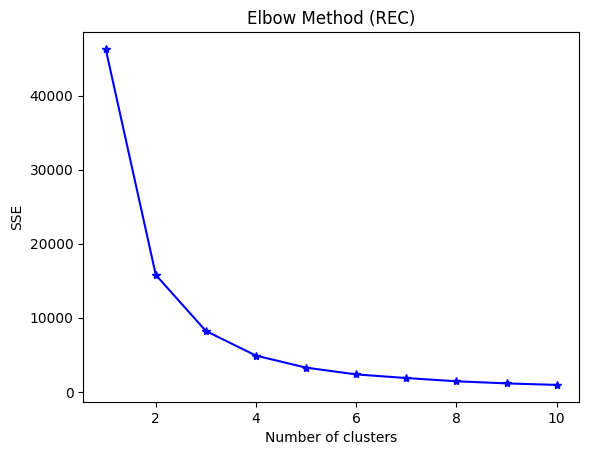

In [126]:
# K-Means Clustering
#k-means
sse=[]
scaler = StandardScaler() 
recency = customer_last_order_timestamp_df1_holdout[['RECENCY_DAYS']].to_numpy()
X_scaled = scaler.fit_transform(recency) 

for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, n_init=20, random_state=1)
    kmeans.fit(X_scaled)
    sse.append(kmeans.inertia_)

plt.plot(range(1, 11), sse, 'b-*')
plt.title('Elbow Method (REC)')
plt.xlabel('Number of clusters')
plt.ylabel('SSE')
plt.show()

In [127]:
# Build 3 Recency Clusters and add it to dataframe 
kmeans = KMeans(n_clusters=3, n_init=20, random_state=1)
#tempCustRec = tempCustRec.to_pandas()
kmeans.fit(customer_last_order_timestamp_df1_holdout[['RECENCY_DAYS']])
customer_last_order_timestamp_df1_holdout['CUST_REC_CLUSTER'] = kmeans.predict(customer_last_order_timestamp_df1_holdout[['RECENCY_DAYS']])


#function for ordering cluster numbers

def order_cluster(cluster_field_name, target_field_name,data,ascending):
    new_cluster_field_name = 'new_' + cluster_field_name
    data_new = data.groupby(cluster_field_name)[target_field_name].mean().reset_index()
    data_new = data_new.sort_values(by=target_field_name,ascending=ascending).reset_index(drop=True)
    data_new['index'] = data_new.index
    data_final = pd.merge(data,data_new[[cluster_field_name,'index']], on=cluster_field_name)
    data_final = data_final.drop([cluster_field_name],axis=1)
    data_final = data_final.rename(columns={"index":cluster_field_name})

    return data_final

customer_last_order_timestamp_df1_holdout = order_cluster('CUST_REC_CLUSTER', 'RECENCY_DAYS',customer_last_order_timestamp_df1_holdout,False)
#see details of the clusters
customer_last_order_timestamp_df1_holdout.groupby('CUST_REC_CLUSTER')['RECENCY_DAYS'].describe()

,count,mean,std,min,25%,50%,75%,max
CUST_REC_CLUSTER,,,,,,,,
0,3445.0,47.389550,13.256134,34.0,38.0,43.0,54.0,162.0
1,11987.0,19.959456,5.712436,13.0,15.0,18.0,24.0,33.0
2,30868.0,5.083485,3.671894,0.0,2.0,5.0,8.0,12.0


In [128]:
customer_last_order_timestamp_df1_holdout.head()

,CUSTOMER_ID,TOTAL_SPENT,YEARS_WITH_US,MONETARY_VALUE,CUSTOMER_FREQUENCY,TOTAL_ORDER,RECENCY_DAYS,MAX(DAYS_BETWEEN),MIN(DAYS_BETWEEN),AVG(DAYS_BETWEEN),LAST_ORDER_TS,LAST_TRANS,DAYS_DF1,TRANS_DATEDIFF1,TRANS_DATEDIFF2,CUST_REC_CLUSTER
0,73237,2253.75,2.893151,778.994944,21.084278,61,22,78,1,17.233333,2022-09-26 18:48:13,2022-10-18 22:56:45,22,5,36,1
1,165441,2857.50,2.953425,967.520760,25.394246,75,13,64,1,14.391892,2022-10-05 18:55:55,2022-10-18 22:56:45,13,19,8,1
2,146959,2432.00,3.013699,806.981719,20.904543,63,16,70,1,17.483871,2022-10-02 11:05:00,2022-10-18 22:56:45,16,24,11,1
3,141714,2179.00,2.731507,797.728141,19.037110,52,30,117,1,18.960784,2022-09-18 21:22:07,2022-10-18 22:56:45,30,4,2,1
4,139777,2319.00,3.035616,763.930616,22.400725,68,24,129,1,16.179104,2022-09-24 17:39:10,2022-10-18 22:56:45,24,1,3,1


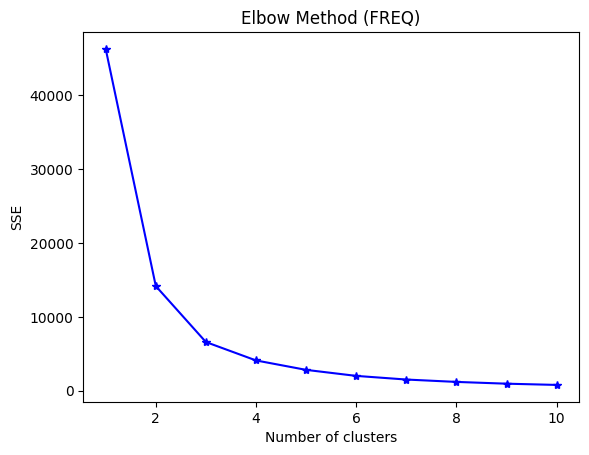

In [129]:
# K-Means Clustering
#k-means
sse=[]
scaler = StandardScaler() 
frequency = customer_last_order_timestamp_df1_holdout[['CUSTOMER_FREQUENCY']].to_numpy()
X_scaled = scaler.fit_transform(frequency) 

for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, n_init=20, random_state=1)
    kmeans.fit(X_scaled)
    sse.append(kmeans.inertia_)

plt.plot(range(1, 11), sse, 'b-*')
plt.title('Elbow Method (FREQ)')
plt.xlabel('Number of clusters')
plt.ylabel('SSE')
plt.show()

In [130]:
#build 3 clusters for frequency and add it to dataframe

kmeans = KMeans(n_clusters=3, n_init=20, random_state=1)
kmeans.fit(customer_last_order_timestamp_df1_holdout[['CUSTOMER_FREQUENCY']])
customer_last_order_timestamp_df1_holdout['CUST_FREQ_CLUSTER'] = kmeans.predict(customer_last_order_timestamp_df1_holdout[['CUSTOMER_FREQUENCY']])

# reuse function for ordering cluster numbers
customer_last_order_timestamp_df1_holdout = order_cluster('CUST_FREQ_CLUSTER', 'CUSTOMER_FREQUENCY',customer_last_order_timestamp_df1_holdout,True)
#see details of the clusters
customer_last_order_timestamp_df1_holdout.groupby('CUST_FREQ_CLUSTER')['CUSTOMER_FREQUENCY'].describe()

,count,mean,std,min,25%,50%,75%,max
CUST_FREQ_CLUSTER,,,,,,,,
0,10657.0,11.773597,1.793350,5.311237,10.483748,11.820696,13.186009,14.919200
1,19850.0,18.066075,1.392474,14.920240,17.029173,18.268270,19.247714,20.172056
2,15793.0,22.281361,1.666575,20.172710,20.973410,21.892451,23.210255,31.941990


In [131]:
customer_last_order_timestamp_df1_holdout.head()

,CUSTOMER_ID,TOTAL_SPENT,YEARS_WITH_US,MONETARY_VALUE,CUSTOMER_FREQUENCY,TOTAL_ORDER,RECENCY_DAYS,MAX(DAYS_BETWEEN),MIN(DAYS_BETWEEN),AVG(DAYS_BETWEEN),LAST_ORDER_TS,LAST_TRANS,DAYS_DF1,TRANS_DATEDIFF1,TRANS_DATEDIFF2,CUST_REC_CLUSTER,CUST_FREQ_CLUSTER
0,73237,2253.75,2.893151,778.994944,21.084278,61,22,78,1,17.233333,2022-09-26 18:48:13,2022-10-18 22:56:45,22,5,36,1,2
1,165441,2857.50,2.953425,967.520760,25.394246,75,13,64,1,14.391892,2022-10-05 18:55:55,2022-10-18 22:56:45,13,19,8,1,2
2,146959,2432.00,3.013699,806.981719,20.904543,63,16,70,1,17.483871,2022-10-02 11:05:00,2022-10-18 22:56:45,16,24,11,1,2
3,139777,2319.00,3.035616,763.930616,22.400725,68,24,129,1,16.179104,2022-09-24 17:39:10,2022-10-18 22:56:45,24,1,3,1,2
4,131163,2746.00,2.928767,937.595923,24.925165,73,16,126,1,14.625000,2022-10-02 20:36:04,2022-10-18 22:56:45,16,12,27,1,2


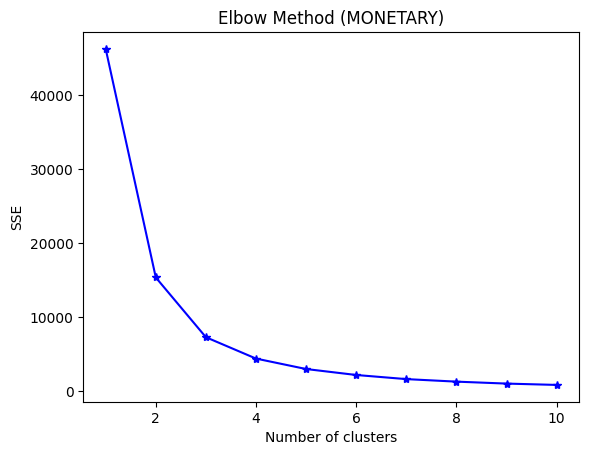

In [132]:
#k-means
sse=[]
scaler = StandardScaler() 
monetary = customer_last_order_timestamp_df1_holdout[['MONETARY_VALUE']]
X_scaled = scaler.fit_transform(monetary) 

for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, n_init=20, random_state=1)
    kmeans.fit(X_scaled)
    sse.append(kmeans.inertia_)

plt.plot(range(1, 11), sse, 'b-*')
plt.title('Elbow Method (MONETARY)')
plt.xlabel('Number of clusters')
plt.ylabel('SSE')
plt.show()

In [133]:
#build 3 clusters for monetary and add it to dataframe

kmeans = KMeans(n_clusters=3, n_init=20, random_state=1)
kmeans.fit(customer_last_order_timestamp_df1_holdout[['MONETARY_VALUE']])
customer_last_order_timestamp_df1_holdout['CUST_MONETARY_CLUSTER'] = kmeans.predict(customer_last_order_timestamp_df1_holdout[['MONETARY_VALUE']])


# reuse function for ordering cluster numbers
customer_last_order_timestamp_df1_holdout = order_cluster('CUST_MONETARY_CLUSTER', 'MONETARY_VALUE',customer_last_order_timestamp_df1_holdout,True)
customer_last_order_timestamp_df1_holdout.groupby("CUST_MONETARY_CLUSTER")["MONETARY_VALUE"].describe()

,count,mean,std,min,25%,50%,75%,max
CUST_MONETARY_CLUSTER,,,,,,,,
0,10945.0,436.378296,79.637579,152.803237,378.406099,439.429759,503.307490,566.069380
1,20860.0,695.645905,62.582673,566.095612,646.296569,702.087233,748.768182,795.259144
2,14495.0,894.362055,80.442846,795.275901,831.264526,875.010808,939.024795,1348.085963


In [134]:
customer_last_order_timestamp_df1_holdout.head()

,CUSTOMER_ID,TOTAL_SPENT,YEARS_WITH_US,MONETARY_VALUE,CUSTOMER_FREQUENCY,TOTAL_ORDER,RECENCY_DAYS,MAX(DAYS_BETWEEN),MIN(DAYS_BETWEEN),AVG(DAYS_BETWEEN),LAST_ORDER_TS,LAST_TRANS,DAYS_DF1,TRANS_DATEDIFF1,TRANS_DATEDIFF2,CUST_REC_CLUSTER,CUST_FREQ_CLUSTER,CUST_MONETARY_CLUSTER
0,73237,2253.75,2.893151,778.994944,21.084278,61,22,78,1,17.233333,2022-09-26 18:48:13,2022-10-18 22:56:45,22,5,36,1,2,1
1,139777,2319.00,3.035616,763.930616,22.400725,68,24,129,1,16.179104,2022-09-24 17:39:10,2022-10-18 22:56:45,24,1,3,1,2,1
2,141537,1872.25,2.736986,684.055381,21.191194,58,14,87,1,17.280702,2022-10-04 09:34:11,2022-10-18 22:56:45,14,5,4,1,2,1
3,90471,2011.25,2.956164,680.358059,20.973126,62,18,98,1,17.393443,2022-09-30 20:04:36,2022-10-18 22:56:45,18,23,1,1,2,1
4,118188,2404.50,3.043836,789.957146,21.026100,64,22,97,1,17.285714,2022-09-26 12:43:17,2022-10-18 22:56:45,22,24,3,1,2,1


In [135]:
# Calculate overall score of customer based on their RFM
customer_last_order_timestamp_df1_holdout['OVERALL_SCORE'] = customer_last_order_timestamp_df1_holdout['CUST_REC_CLUSTER'] + customer_last_order_timestamp_df1_holdout['CUST_FREQ_CLUSTER'] + customer_last_order_timestamp_df1_holdout['CUST_MONETARY_CLUSTER']

# Evaluation
customer_last_order_timestamp_df1_holdout.groupby('OVERALL_SCORE')[['RECENCY_DAYS','CUSTOMER_FREQUENCY','MONETARY_VALUE']].max()

,RECENCY_DAYS,CUSTOMER_FREQUENCY,MONETARY_VALUE
OVERALL_SCORE,,,
0,162,14.891205,566.069380
1,96,19.688796,776.980882
2,115,20.197627,794.960557
3,98,24.455000,1006.908368
4,86,28.879117,1247.049347
5,33,30.560137,1259.960022
6,12,31.941990,1348.085963


In [136]:
customer_last_order_timestamp_df1_holdout.head()

,CUSTOMER_ID,TOTAL_SPENT,YEARS_WITH_US,MONETARY_VALUE,CUSTOMER_FREQUENCY,TOTAL_ORDER,RECENCY_DAYS,MAX(DAYS_BETWEEN),MIN(DAYS_BETWEEN),AVG(DAYS_BETWEEN),LAST_ORDER_TS,LAST_TRANS,DAYS_DF1,TRANS_DATEDIFF1,TRANS_DATEDIFF2,CUST_REC_CLUSTER,CUST_FREQ_CLUSTER,CUST_MONETARY_CLUSTER,OVERALL_SCORE
0,73237,2253.75,2.893151,778.994944,21.084278,61,22,78,1,17.233333,2022-09-26 18:48:13,2022-10-18 22:56:45,22,5,36,1,2,1,4
1,139777,2319.00,3.035616,763.930616,22.400725,68,24,129,1,16.179104,2022-09-24 17:39:10,2022-10-18 22:56:45,24,1,3,1,2,1,4
2,141537,1872.25,2.736986,684.055381,21.191194,58,14,87,1,17.280702,2022-10-04 09:34:11,2022-10-18 22:56:45,14,5,4,1,2,1,4
3,90471,2011.25,2.956164,680.358059,20.973126,62,18,98,1,17.393443,2022-09-30 20:04:36,2022-10-18 22:56:45,18,23,1,1,2,1,4
4,118188,2404.50,3.043836,789.957146,21.026100,64,22,97,1,17.285714,2022-09-26 12:43:17,2022-10-18 22:56:45,22,24,3,1,2,1,4


In [137]:
# Get last 2 weeks before last transaction date provided (second dataframe)
order_df2_holdout = order_header_df.filter(F.datediff("day", F.col("ORDER_TS"), F.col("LAST_DATE")) < 14)
order_df2_holdout.show()

----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
|"ORDER_ID"  |"TRUCK_ID"  |"LOCATION_ID"  |"CUSTOMER_ID"  |"DISCOUNT_ID"  |"SHIFT_ID"  |"SHIFT_START_TIME"  |"SHIFT_END_TIME"  |"ORDER_CHANNEL"  |"ORDER_TS"           |"SERVED_TS"  |"ORDER_CURRENCY"  |"ORDER_AMOUNT"  |"ORDER_TAX_AMOUNT"  |"ORDER_DISCOUNT_AMOUNT"  |"ORDER_TOTAL"  |"CUSTOMER_ID_US"  |"LAST_DATE"          |
----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
|4063760     |16          |1483

In [138]:
# Ensure timeframe is correct
order_df2_holdout.agg(F.min('ORDER_TS')).show()
order_df2_holdout.agg(F.max('ORDER_TS')).show()

-----------------------
|"MIN(ORDER_TS)"      |
-----------------------
|2022-10-19 08:00:15  |
-----------------------

-----------------------
|"MAX(ORDER_TS)"      |
-----------------------
|2022-11-01 22:58:56  |
-----------------------



In [139]:
# Getting the earliest purchase date for each customer in df2
customer_first_order_timestamp_df2_holdout = order_df2_holdout.groupBy("CUSTOMER_ID").agg(F.min("ORDER_TS").alias("FIRST_ORDER_TS"))
customer_first_order_timestamp_df2_holdout = customer_first_order_timestamp_df2_holdout.sort(col("FIRST_ORDER_TS"))
customer_first_order_timestamp_df2_holdout.show()

---------------------------------------
|"CUSTOMER_ID"  |"FIRST_ORDER_TS"     |
---------------------------------------
|184287         |2022-10-19 08:00:15  |
|42060          |2022-10-19 08:00:46  |
|196281         |2022-10-19 08:00:59  |
|127806         |2022-10-19 08:01:29  |
|170016         |2022-10-19 08:01:47  |
|64450          |2022-10-19 08:01:53  |
|191049         |2022-10-19 08:01:59  |
|118969         |2022-10-19 08:02:19  |
|192268         |2022-10-19 08:04:20  |
|95980          |2022-10-19 08:04:33  |
---------------------------------------



In [140]:
# Getting first order date
earliest_transaction_df2_holdout = order_df2_holdout.agg(F.min("ORDER_TS").alias("FIRST_ORDER_TS")).collect()[0][0]
customer_first_order_timestamp_df2_holdout = customer_first_order_timestamp_df2_holdout.withColumn("FIRST_TRANS", F.iff(F.col("CUSTOMER_ID") == F.col("CUSTOMER_ID"), earliest_transaction_df2_holdout, earliest_transaction_df2_holdout))
customer_first_order_timestamp_df2_holdout.show()

-------------------------------------------------------------
|"CUSTOMER_ID"  |"FIRST_ORDER_TS"     |"FIRST_TRANS"        |
-------------------------------------------------------------
|184287         |2022-10-19 08:00:15  |2022-10-19 08:00:15  |
|42060          |2022-10-19 08:00:46  |2022-10-19 08:00:15  |
|196281         |2022-10-19 08:00:59  |2022-10-19 08:00:15  |
|127806         |2022-10-19 08:01:29  |2022-10-19 08:00:15  |
|170016         |2022-10-19 08:01:47  |2022-10-19 08:00:15  |
|64450          |2022-10-19 08:01:53  |2022-10-19 08:00:15  |
|191049         |2022-10-19 08:01:59  |2022-10-19 08:00:15  |
|118969         |2022-10-19 08:02:19  |2022-10-19 08:00:15  |
|192268         |2022-10-19 08:04:20  |2022-10-19 08:00:15  |
|95980          |2022-10-19 08:04:33  |2022-10-19 08:00:15  |
-------------------------------------------------------------



In [141]:
# Getting the date diff from customer last order to the date 2 weeks before the latest provided transaction date in df1
customer_first_order_timestamp_df2_holdout = customer_first_order_timestamp_df2_holdout.withColumn("days_df2", F.datediff("day", customer_first_order_timestamp_df2_holdout["FIRST_TRANS"], customer_first_order_timestamp_df2_holdout["FIRST_ORDER_TS"]))
customer_first_order_timestamp_df2_holdout.show()

--------------------------------------------------------------------------
|"CUSTOMER_ID"  |"FIRST_ORDER_TS"     |"FIRST_TRANS"        |"DAYS_DF2"  |
--------------------------------------------------------------------------
|190448         |2022-10-23 15:05:57  |2022-10-19 08:00:15  |4           |
|171229         |2022-10-23 15:07:04  |2022-10-19 08:00:15  |4           |
|112636         |2022-10-23 15:08:23  |2022-10-19 08:00:15  |4           |
|59351          |2022-10-23 15:08:53  |2022-10-19 08:00:15  |4           |
|5439           |2022-10-23 15:08:59  |2022-10-19 08:00:15  |4           |
|130937         |2022-10-23 15:09:48  |2022-10-19 08:00:15  |4           |
|148016         |2022-10-23 15:09:59  |2022-10-19 08:00:15  |4           |
|35815          |2022-10-23 15:10:18  |2022-10-19 08:00:15  |4           |
|184976         |2022-10-23 15:11:16  |2022-10-19 08:00:15  |4           |
|185091         |2022-10-23 15:11:17  |2022-10-19 08:00:15  |4           |
-------------------------

In [142]:
# convert 2nd dataframe to pandas
customer_first_order_timestamp_df2_holdout = customer_first_order_timestamp_df2_holdout.to_pandas()

In [143]:
customer_first_order_timestamp_df2_holdout.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 33053 entries, 0 to 33052
Data columns (total 4 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   CUSTOMER_ID     33053 non-null  int32         
 1   FIRST_ORDER_TS  33053 non-null  datetime64[ns]
 2   FIRST_TRANS     33053 non-null  datetime64[ns]
 3   DAYS_DF2        33053 non-null  int32         
dtypes: datetime64[ns](2), int32(2)
memory usage: 774.8 KB


In [144]:
customer_last_order_timestamp_df1_holdout.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 46300 entries, 0 to 46299
Data columns (total 19 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   CUSTOMER_ID            46300 non-null  int32         
 1   TOTAL_SPENT            46300 non-null  float64       
 2   YEARS_WITH_US          46300 non-null  float64       
 3   MONETARY_VALUE         46300 non-null  float64       
 4   CUSTOMER_FREQUENCY     46300 non-null  float64       
 5   TOTAL_ORDER            46300 non-null  int64         
 6   RECENCY_DAYS           46300 non-null  int32         
 7   MAX(DAYS_BETWEEN)      46300 non-null  int32         
 8   MIN(DAYS_BETWEEN)      46300 non-null  int32         
 9   AVG(DAYS_BETWEEN)      46300 non-null  object        
 10  LAST_ORDER_TS          46300 non-null  datetime64[ns]
 11  LAST_TRANS             46300 non-null  datetime64[ns]
 12  DAYS_DF1               46300 non-null  int32         
 13  T

In [145]:
# merge first dataframe and second dataframe 
# since the number of rows in the first and second dataframe are different, we can infer that there are some customers that did not make an order in the 14 days timeframe
holdout_df = pd.merge(customer_last_order_timestamp_df1_holdout, customer_first_order_timestamp_df2_holdout, on='CUSTOMER_ID', how='left')

# drop irrelevant columns
holdout_df = holdout_df.drop(["FIRST_ORDER_TS", "FIRST_TRANS", "LAST_ORDER_TS", "LAST_TRANS"], axis=1)
holdout_df.head()

,CUSTOMER_ID,TOTAL_SPENT,YEARS_WITH_US,MONETARY_VALUE,CUSTOMER_FREQUENCY,TOTAL_ORDER,RECENCY_DAYS,MAX(DAYS_BETWEEN),MIN(DAYS_BETWEEN),AVG(DAYS_BETWEEN),DAYS_DF1,TRANS_DATEDIFF1,TRANS_DATEDIFF2,CUST_REC_CLUSTER,CUST_FREQ_CLUSTER,CUST_MONETARY_CLUSTER,OVERALL_SCORE,DAYS_DF2
0,73237,2253.75,2.893151,778.994944,21.084278,61,22,78,1,17.233333,22,5,36,1,2,1,4,NaN
1,139777,2319.00,3.035616,763.930616,22.400725,68,24,129,1,16.179104,24,1,3,1,2,1,4,2.0
2,141537,1872.25,2.736986,684.055381,21.191194,58,14,87,1,17.280702,14,5,4,1,2,1,4,5.0
3,90471,2011.25,2.956164,680.358059,20.973126,62,18,98,1,17.393443,18,23,1,1,2,1,4,NaN
4,118188,2404.50,3.043836,789.957146,21.026100,64,22,97,1,17.285714,22,24,3,1,2,1,4,5.0


In [146]:
holdout_df["TARGET"] = holdout_df["DAYS_DF1"] + holdout_df["DAYS_DF2"]
holdout_df["TARGET"].fillna(np.floor(holdout_df["AVG(DAYS_BETWEEN)"]) + holdout_df["DAYS_DF1"], inplace = True)
holdout_df = holdout_df.drop(["DAYS_DF1", "DAYS_DF2"], axis=1)
holdout_df.head()

,CUSTOMER_ID,TOTAL_SPENT,YEARS_WITH_US,MONETARY_VALUE,CUSTOMER_FREQUENCY,TOTAL_ORDER,RECENCY_DAYS,MAX(DAYS_BETWEEN),MIN(DAYS_BETWEEN),AVG(DAYS_BETWEEN),TRANS_DATEDIFF1,TRANS_DATEDIFF2,CUST_REC_CLUSTER,CUST_FREQ_CLUSTER,CUST_MONETARY_CLUSTER,OVERALL_SCORE,TARGET
0,73237,2253.75,2.893151,778.994944,21.084278,61,22,78,1,17.233333,5,36,1,2,1,4,39.0
1,139777,2319.00,3.035616,763.930616,22.400725,68,24,129,1,16.179104,1,3,1,2,1,4,26.0
2,141537,1872.25,2.736986,684.055381,21.191194,58,14,87,1,17.280702,5,4,1,2,1,4,19.0
3,90471,2011.25,2.956164,680.358059,20.973126,62,18,98,1,17.393443,23,1,1,2,1,4,35.0
4,118188,2404.50,3.043836,789.957146,21.026100,64,22,97,1,17.285714,24,3,1,2,1,4,27.0


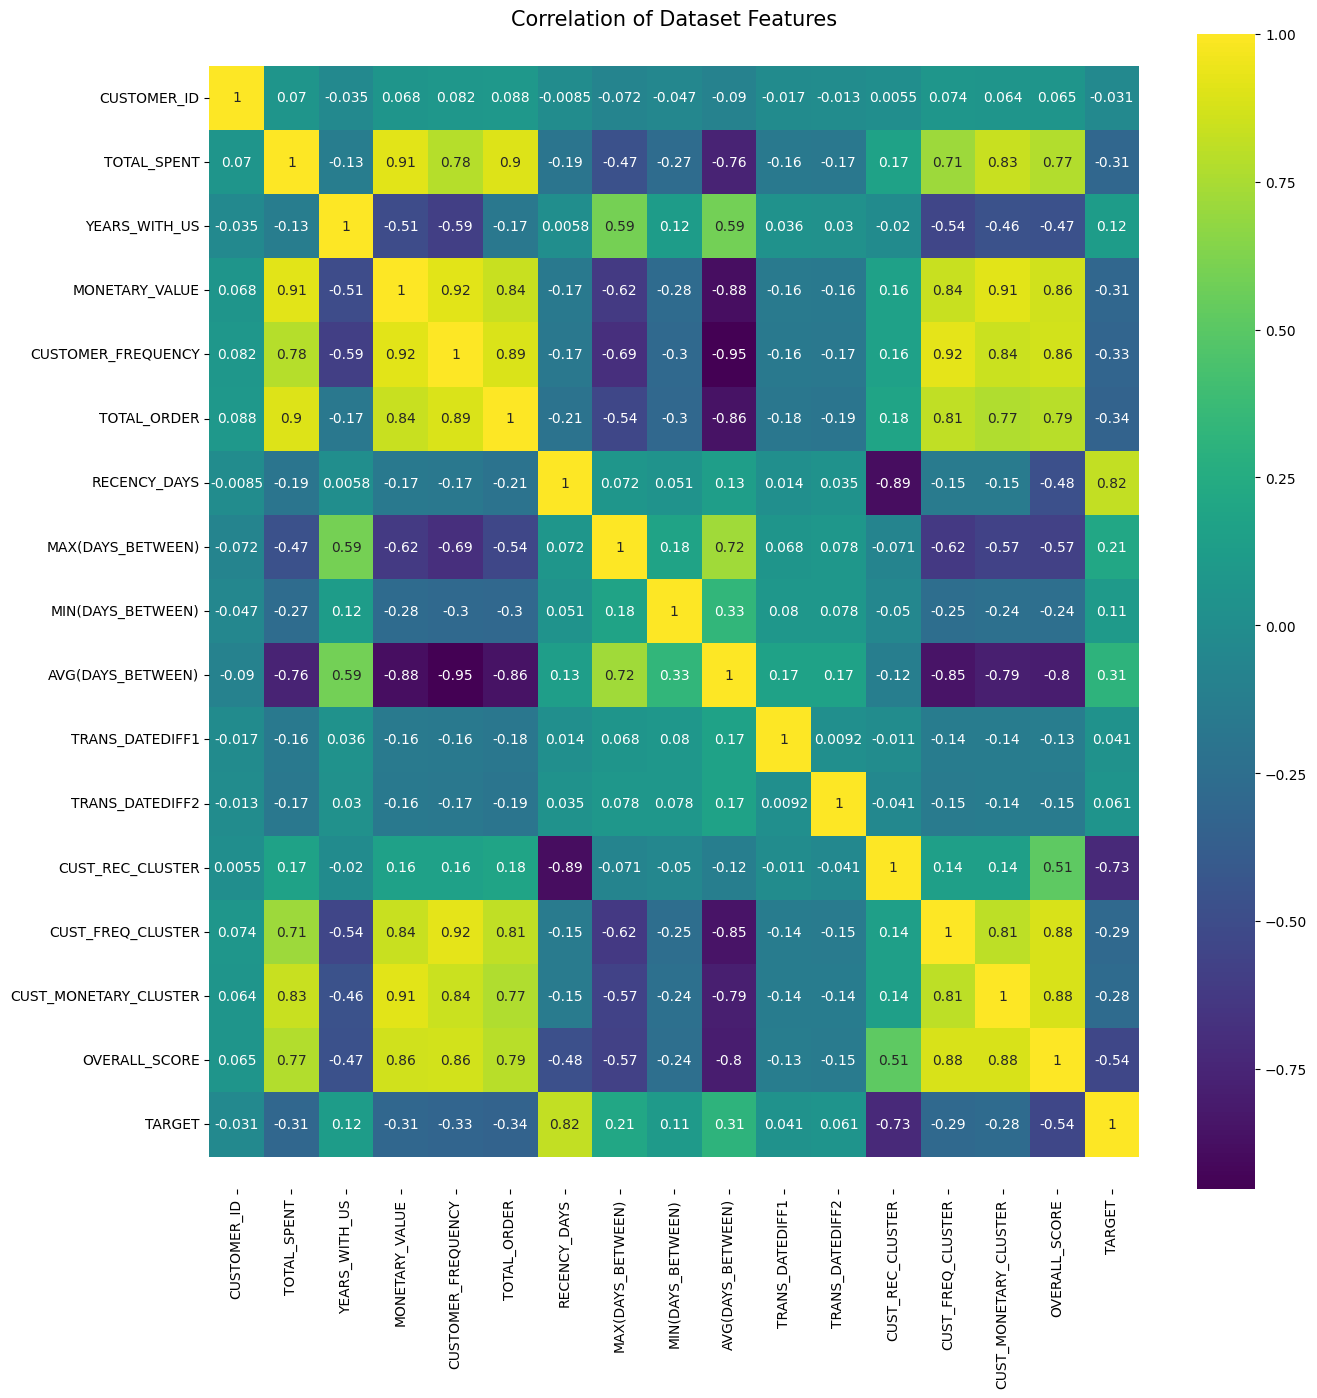

In [147]:
colormap = plt.cm.viridis
plt.figure(figsize=(15,15))
plt.title('Correlation of Dataset Features', size=15)
ax = sns.heatmap(holdout_df.astype(float).corr(), cmap=colormap, annot=True)
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)
plt.show()

In [148]:
# save dataframe of customer_id 
customer_id_df_holdout = holdout_df["CUSTOMER_ID"]

holdout_df = holdout_df.drop(["CUSTOMER_ID"],  axis = 1)

holdout_df.head()

,TOTAL_SPENT,YEARS_WITH_US,MONETARY_VALUE,CUSTOMER_FREQUENCY,TOTAL_ORDER,RECENCY_DAYS,MAX(DAYS_BETWEEN),MIN(DAYS_BETWEEN),AVG(DAYS_BETWEEN),TRANS_DATEDIFF1,TRANS_DATEDIFF2,CUST_REC_CLUSTER,CUST_FREQ_CLUSTER,CUST_MONETARY_CLUSTER,OVERALL_SCORE,TARGET
0,2253.75,2.893151,778.994944,21.084278,61,22,78,1,17.233333,5,36,1,2,1,4,39.0
1,2319.00,3.035616,763.930616,22.400725,68,24,129,1,16.179104,1,3,1,2,1,4,26.0
2,1872.25,2.736986,684.055381,21.191194,58,14,87,1,17.280702,5,4,1,2,1,4,19.0
3,2011.25,2.956164,680.358059,20.973126,62,18,98,1,17.393443,23,1,1,2,1,4,35.0
4,2404.50,3.043836,789.957146,21.026100,64,22,97,1,17.285714,24,3,1,2,1,4,27.0


In [149]:
# Drop target
target = holdout_df['TARGET']
holdout_df.drop('TARGET', axis = 1, inplace = True)

scaler = StandardScaler()
scaler.fit(holdout_df)

holdout_scaled = scaler.transform(holdout_df)
holdout_scaled = pd.DataFrame(holdout_scaled, columns=holdout_df.columns)

#assign target variable back to scaled data frame
holdout_scaled = holdout_scaled.assign(TARGET = target)

holdout_scaled.head()

,TOTAL_SPENT,YEARS_WITH_US,MONETARY_VALUE,CUSTOMER_FREQUENCY,TOTAL_ORDER,RECENCY_DAYS,MAX(DAYS_BETWEEN),MIN(DAYS_BETWEEN),AVG(DAYS_BETWEEN),TRANS_DATEDIFF1,TRANS_DATEDIFF2,CUST_REC_CLUSTER,CUST_FREQ_CLUSTER,CUST_MONETARY_CLUSTER,OVERALL_SCORE,TARGET
0,0.425477,-0.260514,0.450068,0.720036,0.752296,0.756224,-0.728980,-0.25936,-0.698591,-0.648675,1.716305,-0.948064,1.189167,-0.103996,0.135294,39.0
1,0.558672,0.160706,0.367814,1.033003,1.410051,0.908730,-0.003985,-0.25936,-0.857758,-0.952516,-0.784940,-0.948064,1.189167,-0.103996,0.135294,26.0
2,-0.353282,-0.722240,-0.068323,0.745454,0.470401,0.146201,-0.601040,-0.25936,-0.691439,-0.648675,-0.709144,-0.948064,1.189167,-0.103996,0.135294,19.0
3,-0.069541,-0.074207,-0.088512,0.693611,0.846261,0.451213,-0.444668,-0.25936,-0.674418,0.718608,-0.936530,-0.948064,1.189167,-0.103996,0.135294,35.0
4,0.733204,0.185009,0.509925,0.706205,1.034191,0.756224,-0.458884,-0.25936,-0.690683,0.794568,-0.784940,-0.948064,1.189167,-0.103996,0.135294,27.0


In [150]:
X_holdout = holdout_scaled.copy()

X_holdout = X_holdout.reindex(list(X_test.columns), axis=1)
y_holdout = holdout_scaled['TARGET']

modelHoldoutResults = pd.DataFrame(columns=['Model', 'Holdout_MSE', 'Holdout_R^2'])

Linear Regression


In [151]:
holdout_mse = mean_squared_error(lg.predict(X_holdout), y_holdout)
print('The Holdout Mean Squared Error for Linear Regression Model is: ', holdout_mse)

holdout_R2 = lg.score(X_holdout, y_holdout)
print('The Holdout R^2 for Linear Regression Model is: ', holdout_R2)

# Define the new row to be added
new_row = {'Model' : 'Linear Regression','Holdout_MSE': holdout_mse, 'Holdout_R^2': holdout_R2}
# Use the loc method to add the new row to the DataFrame
modelHoldoutResults.loc[len(modelHoldoutResults)] = new_row

The Holdout Mean Squared Error for Linear Regression Model is:  80.9446947581702
The Holdout R^2 for Linear Regression Model is:  0.7055001203665953


Decision Tree

In [152]:
holdout_mse = mean_squared_error(dt.predict(X_holdout), y_holdout)
print('The Holdout Mean Squared Error for Decision Tree Model is: ', holdout_mse)

holdout_R2 = dt.score(X_holdout, y_holdout)
print('The Holdout R^2 for Decision Tree Model is: ', holdout_R2)

# Define the new row to be added
new_row = {'Model' : 'Decision Tree','Holdout_MSE': holdout_mse, 'Holdout_R^2': holdout_R2}
# Use the loc method to add the new row to the DataFrame
modelHoldoutResults.loc[len(modelHoldoutResults)] = new_row

The Holdout Mean Squared Error for Decision Tree Model is:  111.96609718911184
The Holdout R^2 for Decision Tree Model is:  0.5926354130591458


XGBoost

In [153]:
holdout_mse = mean_squared_error(xgb.predict(X_holdout), y_holdout)
print('The Holdout Mean Squared Error for XGBoost Model is: ', holdout_mse)

holdout_R2 = xgb.score(X_holdout, y_holdout)
print('The Holdout R^2 for XGBoost Model is: ', holdout_R2)

# Define the new row to be added
new_row = {'Model' : 'XGBoost','Holdout_MSE': holdout_mse, 'Holdout_R^2': holdout_R2}
# Use the loc method to add the new row to the DataFrame
modelHoldoutResults.loc[len(modelHoldoutResults)] = new_row

The Holdout Mean Squared Error for XGBoost Model is:  88.1216733046628
The Holdout R^2 for XGBoost Model is:  0.6793882260122063


ADA Boost

In [154]:
holdout_mse = mean_squared_error(ada.predict(X_holdout), y_holdout)
print('The Holdout Mean Squared Error for ADA Boost Model is: ', holdout_mse)

holdout_R2 = ada.score(X_holdout, y_holdout)
print('The Holdout R^2 for ADA Boost Model is: ', holdout_R2)

# Define the new row to be added
new_row = {'Model' : 'ADA Boost','Holdout_MSE': holdout_mse, 'Holdout_R^2': holdout_R2}
# Use the loc method to add the new row to the DataFrame
modelHoldoutResults.loc[len(modelHoldoutResults)] = new_row

The Holdout Mean Squared Error for ADA Boost Model is:  94.36532881917181
The Holdout R^2 for ADA Boost Model is:  0.6566720269705175


In [155]:
modelHoldoutResults

,Model,Holdout_MSE,Holdout_R^2
0,Linear Regression,80.944695,0.705500
1,Decision Tree,111.966097,0.592635
2,XGBoost,88.121673,0.679388
3,ADA Boost,94.365329,0.656672


In [156]:
model_results_final = pd.merge(modelTestResults, modelHoldoutResults, how='left', on='Model')
model_results_final

,Model,Train_MSE,Test_MSE,Train_R^2,Test_R^2,Cross_Val_Train_MSE,Cross_Val_Test_MSE,Holdout_MSE,Holdout_R^2
0,Linear Regression,80.169740,81.333037,0.718540,0.726403,NaN,NaN,80.944695,0.705500
1,Decision Tree,109.271984,111.782013,0.616368,0.623976,109.999589,123.694318,111.966097,0.592635
2,XGBoost,51.252418,88.251579,0.820063,0.703130,54.264276,90.885808,88.121673,0.679388
3,ADA Boost,88.793483,90.565252,0.688264,0.695347,91.050584,97.727145,94.365329,0.656672


In [164]:
y_predict = lg.predict(X_holdout)
predicted = pd.DataFrame(y_predict, columns=['PREDICTED'], index=X_holdout.index.tolist())
predicted = pd.merge(holdout_df, predicted, left_index=True, right_index=True)
predicted = pd.merge(customer_id_df_holdout, predicted, left_index=True, right_index=True)
predicted = pd.merge(predicted, target, left_index=True, right_index=True)

predicted['PREDICTED'] = predicted['PREDICTED'].round()
predicted['CHURN'] = np.where(predicted['PREDICTED'] <= 14, 0, 1)

predicted

,CUSTOMER_ID,TOTAL_SPENT,YEARS_WITH_US,MONETARY_VALUE,CUSTOMER_FREQUENCY,TOTAL_ORDER,RECENCY_DAYS,MAX(DAYS_BETWEEN),MIN(DAYS_BETWEEN),AVG(DAYS_BETWEEN),TRANS_DATEDIFF1,TRANS_DATEDIFF2,CUST_REC_CLUSTER,CUST_FREQ_CLUSTER,CUST_MONETARY_CLUSTER,OVERALL_SCORE,PREDICTED,TARGET,CHURN
0,73237,2253.75,2.893151,778.994944,21.084278,61,22,78,1,17.233333,5,36,1,2,1,4,31.0,39.0,1
1,139777,2319.00,3.035616,763.930616,22.400725,68,24,129,1,16.179104,1,3,1,2,1,4,33.0,26.0,1
2,141537,1872.25,2.736986,684.055381,21.191194,58,14,87,1,17.280702,5,4,1,2,1,4,23.0,19.0,1
3,90471,2011.25,2.956164,680.358059,20.973126,62,18,98,1,17.393443,23,1,1,2,1,4,27.0,35.0,1
4,118188,2404.50,3.043836,789.957146,21.026100,64,22,97,1,17.285714,24,3,1,2,1,4,31.0,27.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
46295,131728,1658.00,3.339726,496.447912,12.875308,43,40,179,1,28.071429,2,11,0,0,0,0,55.0,68.0,1
46296,59904,1577.75,3.482192,453.091042,11.199842,39,53,338,1,32.052632,10,6,0,0,0,0,71.0,53.0,1
46297,140813,1510.00,2.679452,563.548069,13.435583,36,63,119,1,26.142857,20,5,0,0,0,0,78.0,65.0,1
46298,186193,1279.00,2.572603,497.161824,13.993609,36,51,166,1,25.371429,10,2,0,0,0,0,66.0,52.0,1


In [165]:
#importing customer segmentation
cust_seg = pd.read_csv(r'C:\Users\gwyne\Desktop\industry currency project\assignment 3\ICP-ASG3\clustering_model\cluster_results.csv')
cust_seg.head()

,CUSTOMER_FREQUENCY,MONETARY_VALUE,CLUSTER,CUSTOMER_ID
0,-1.279354,-1.354681,1,118
1,-0.973178,-0.882622,1,189
2,-1.053047,-1.267852,1,204
3,-1.612963,-1.026743,1,42
4,-1.656606,-1.752784,1,59


In [166]:
cust_seg = cust_seg[['CUSTOMER_ID', 'CLUSTER']]
cust_seg.head()

,CUSTOMER_ID,CLUSTER
0,118,1
1,189,1
2,204,1
3,42,1
4,59,1


In [168]:
# merge the customer segmentation dataframe to the customer details
cust_seg = pd.merge(predicted, cust_seg, how='left', on='CUSTOMER_ID')
cust_seg.head()


,CUSTOMER_ID,TOTAL_SPENT,YEARS_WITH_US,MONETARY_VALUE,CUSTOMER_FREQUENCY,TOTAL_ORDER,RECENCY_DAYS,MAX(DAYS_BETWEEN),MIN(DAYS_BETWEEN),AVG(DAYS_BETWEEN),TRANS_DATEDIFF1,TRANS_DATEDIFF2,CUST_REC_CLUSTER,CUST_FREQ_CLUSTER,CUST_MONETARY_CLUSTER,OVERALL_SCORE,PREDICTED,TARGET,CHURN,CLUSTER
0,73237,2253.75,2.893151,778.994944,21.084278,61,22,78,1,17.233333,5,36,1,2,1,4,31.0,39.0,1,0
1,139777,2319.00,3.035616,763.930616,22.400725,68,24,129,1,16.179104,1,3,1,2,1,4,33.0,26.0,1,2
2,141537,1872.25,2.736986,684.055381,21.191194,58,14,87,1,17.280702,5,4,1,2,1,4,23.0,19.0,1,0
3,90471,2011.25,2.956164,680.358059,20.973126,62,18,98,1,17.393443,23,1,1,2,1,4,27.0,35.0,1,0
4,118188,2404.50,3.043836,789.957146,21.026100,64,22,97,1,17.285714,24,3,1,2,1,4,31.0,27.0,1,2


In [171]:
cust_seg.to_csv('NextPurchaseCustSeg.csv')

In [ ]:
predicted.to_csv('NextPurchase.csv')

In [ ]:
import pickle
pickle.dump(lg, open('NextPurchase.pkl', 'wb'))